In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.14
3.11.6
1.11.3


In [2]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6


# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.02*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    design_nodes.append(i)
    if [xs[i],ys[i]]!= [x_span/2,0] and [xs[i],ys[i]] != [0,y_span/2] and [xs[i],ys[i]] != [x_span/2,y_span] and [xs[i],ys[i]] != [x_span,y_span/2]:
        #design_nodes.append(i)
        if [xs[i],ys[i]]== [0,0] or [xs[i],ys[i]]== [x_span/2,y_span/2] or [xs[i],ys[i]]== [x_span,0] or [xs[i],ys[i]]== [0,y_span] or [xs[i],ys[i]]== [x_span,y_span]:
            loading_nodes.append(i)
        
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

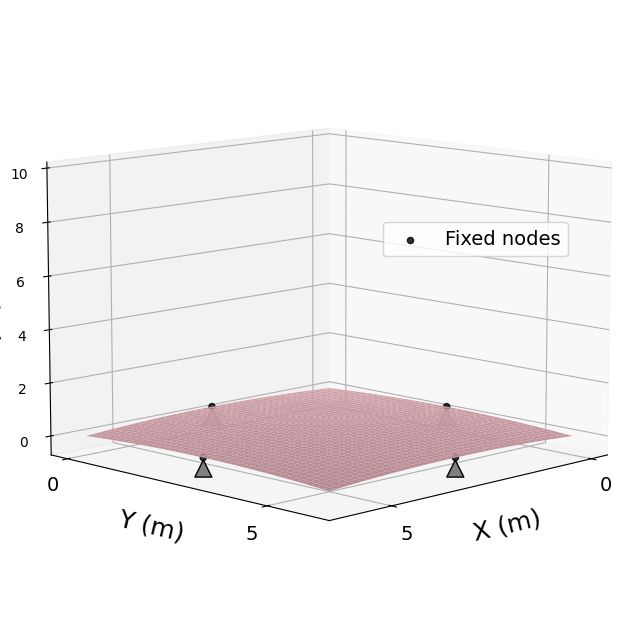

In [3]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

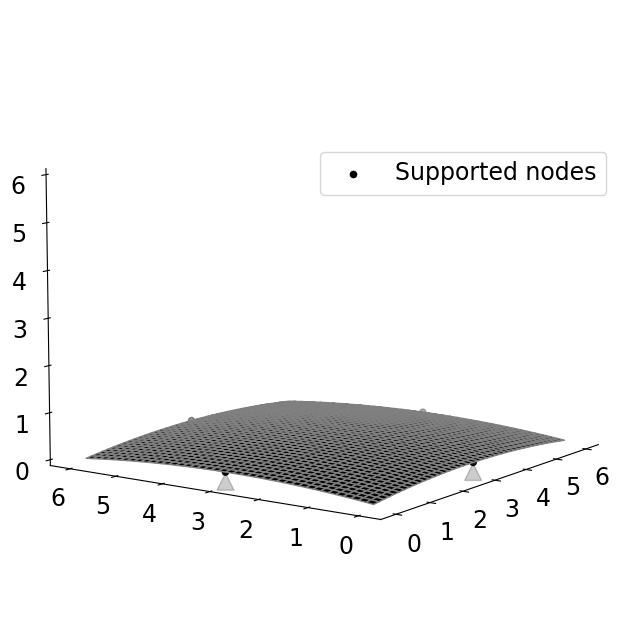

In [4]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -145)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

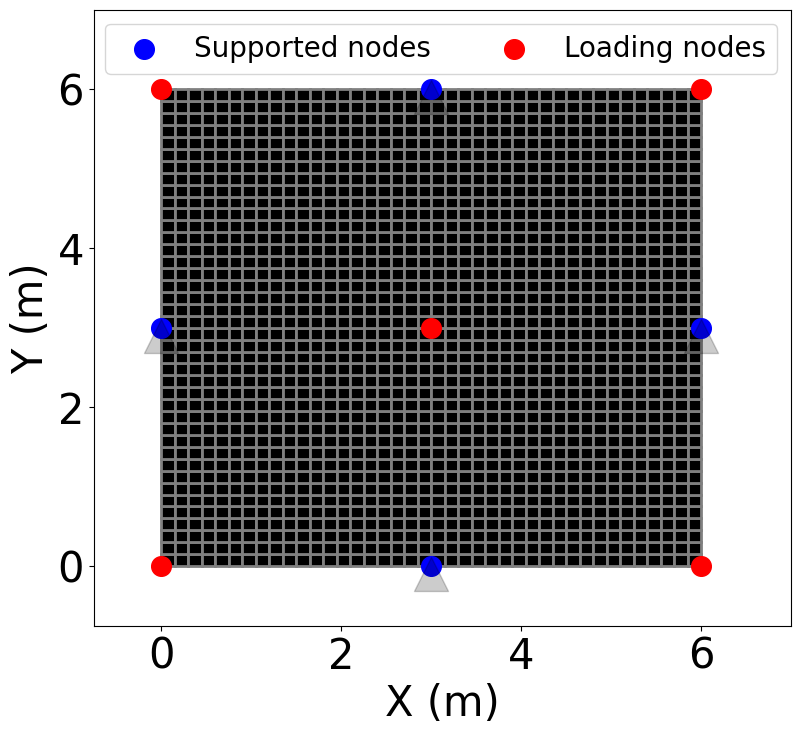

In [5]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [6]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

Mapping for nodal distance filter

In [7]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [8]:
B_ij.shape

(1681, 1681)

In [9]:
n_node/2

840.5

In [10]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

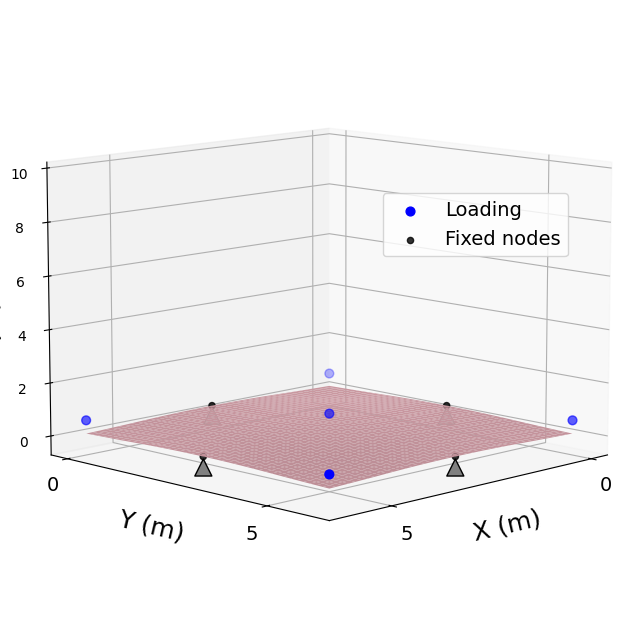

In [11]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [12]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [13]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [14]:
B_ij_shell.shape

(1600, 1600)

In [15]:
#W(A): total volume
def coeff_E(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**7*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

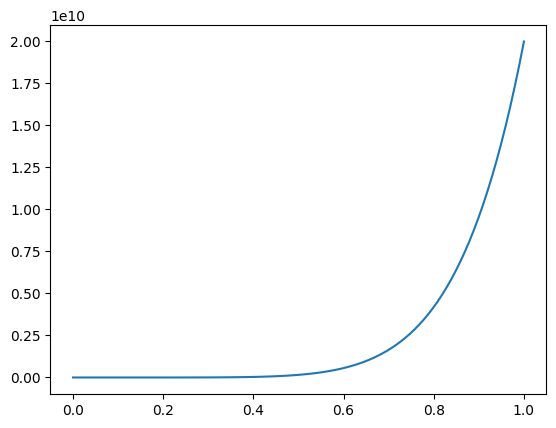

In [16]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [17]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




2024-07-14 01:57:58.677175: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:462] TfrtCpuClient created.
2024-07-14 01:57:58.759690: I external/xla/xla/service/service.cc:168] XLA service 0x55c97b027120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-14 01:57:58.759718: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-07-14 01:57:58.760054: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:633] Using BFC allocator.
2024-07-14 01:57:58.760103: I external/xla/xla/pjrt/gpu/gpu_helpers.cc:105] XLA backend allocating 31950225408 bytes on device 0 for BFCAllocator.


In [18]:
model.solve()

In [19]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Nodal parameter: for shape optimization
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [20]:
sso_model.parameter_values.shape

(3281,)

In [21]:
sso_model.eleparameters_values.shape

(1600,)

In [22]:
C_hist = []
mu_sum_list =[]
def objective_filter(x,sso_model=sso_model):
    '''
    Design parameters:
    node params: normalized control point (pre filtered)
    ele params: pre-filtered mu
    '''
    node_params = x[:sso_model.nodeparameters_values.shape[0]]
    ele_params = x[sso_model.nodeparameters_values.shape[0]:]
    
    #Normalized pt - Unnormalized Control pt - filtered actual geometry pt
    p = zs.copy()
    p[design_nodes]= og_p(node_params) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    sso_model.update_nodeparameter(z) # Update the model
    
    #pre-filtered mu
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu) #Penalized Young's modulus
    sso_model.update_eleparameter(E_step) # Update the model
    
    #JAX-SSO
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    print("{}th iteration, C = {} ".format(len(C_hist),C))
    mu_sum_list.append(np.sum(ele_params))
    
    #Chain rule for final gradient
    sens_node = sens[:sso_model.nodeparameters_values.shape[0]]
    sens_shape = np.asarray((sens_node@B_ij[design_nodes])[design_nodes],dtype=float)
    sens_shape_norm = (sens_shape@jacfwd(og_p)(x[:sso_model.nodeparameters_values.shape[0]]))
    
    sens_ele =sens[sso_model.nodeparameters_values.shape[0]:]
    sens_topo = sens_ele@jacfwd(coeff_E)(B_ij_shell@x[sso_model.nodeparameters_values.shape[0]:])
    sens_topo_final = sens_topo@B_ij_shell
    
    if len(C_hist)%5==0:
        i = len(C_hist)
        print(jnp.sum(ele_params))
        plt_plan(filtered_mu,i)
    return float(C), jnp.hstack((sens_shape_norm,sens_topo_final))

In [26]:
x_ini = jnp.hstack((0.5*jnp.abs(norm_p(sso_model.nodeparameters_values)),0.1*np.ones(sso_model.eleparameters_values.shape[0])))

# Implementing MMA

In [23]:
import nlopt

In [24]:
#Nlopt objective and constraints
def f(x,grad):
    res_1,res_2 = objective_filter(x)
    if grad.size>0:
        grad[:] = res_2

    return res_1

#Constraints on volume minimization
def vol(x):
    '''
    Return the volume constraints
    '''
    mu = x[sso_model.nodeparameters_values.shape[0]:] #the density
    return jnp.sum(mu)-0.5*sso_model.eleparameters_values.shape[0]
def fc(x,grad):
    res_1,res_2 = value_and_grad(vol)(x) 
    if grad.size>0:
        grad[:] = res_2

    return float(res_1)

1th iteration, C = 2069037049.2602236 
2th iteration, C = 17332211857.788906 
3th iteration, C = 17332157784.467022 
4th iteration, C = 17331616976.715664 
5th iteration, C = 17326210062.50567 
402.26012067405145


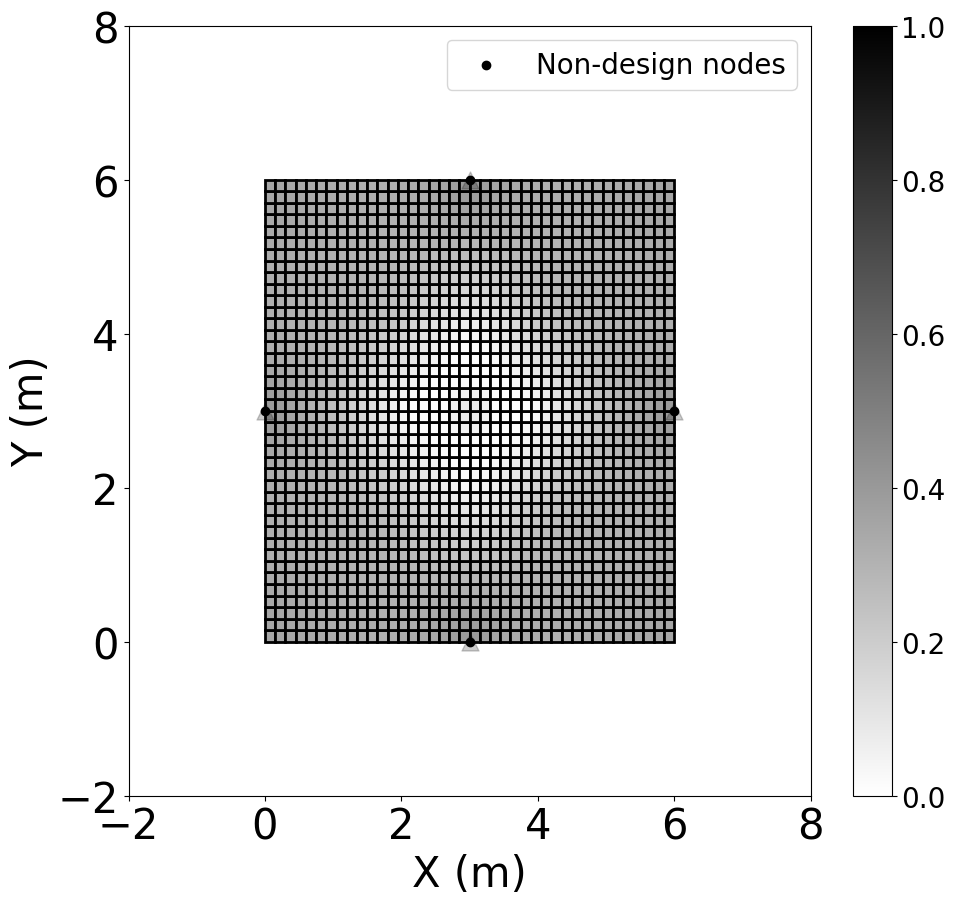

6th iteration, C = 17237326588.050606 
7th iteration, C = 16410920459.424063 
8th iteration, C = 7855240705.466739 
9th iteration, C = 8880797.126570072 
10th iteration, C = 634051.4754000827 
418.0867642912274


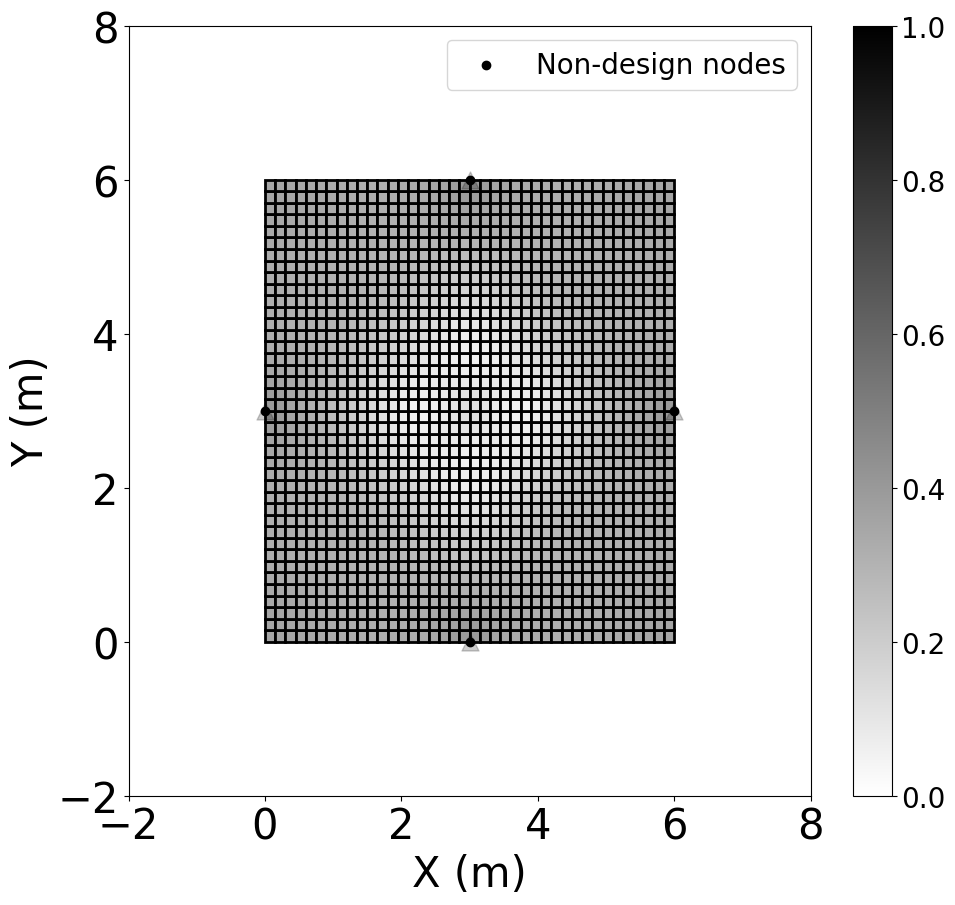

11th iteration, C = 619845.0790427006 
12th iteration, C = 510622.50898244063 
13th iteration, C = 280860.06878041296 
14th iteration, C = 256736.53562844472 
15th iteration, C = 120288.71570023414 
437.3325138264354


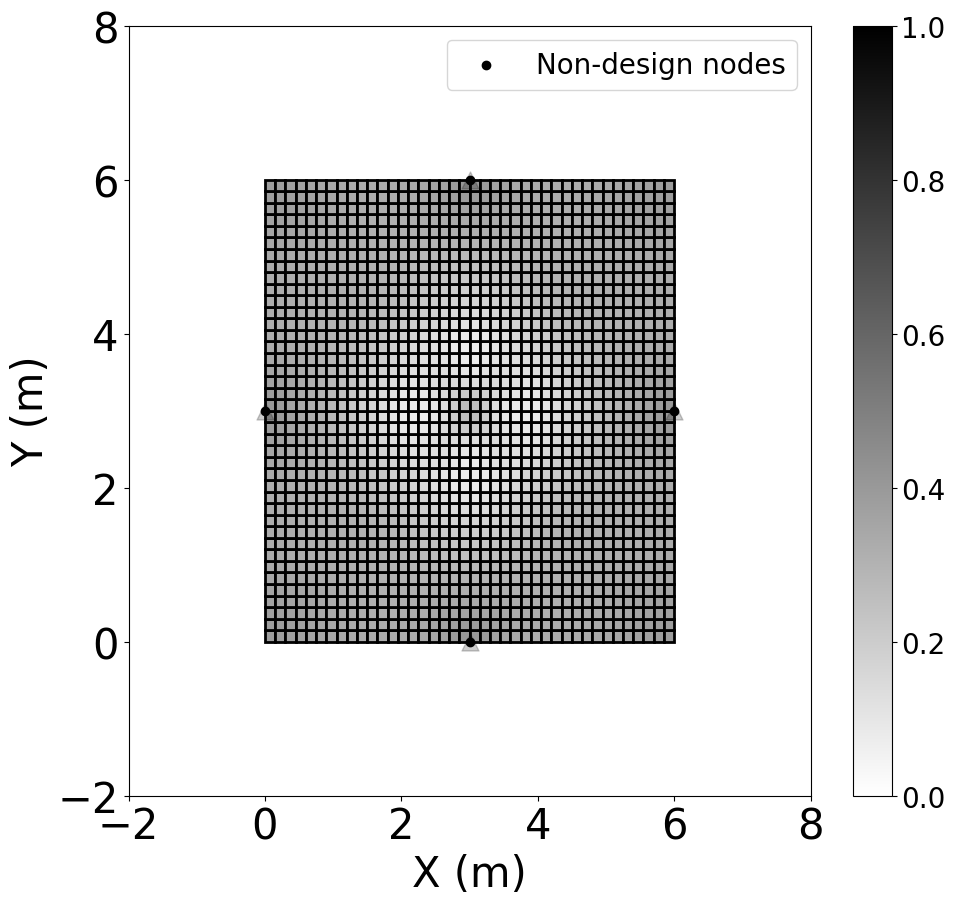

16th iteration, C = 4537.753106241568 
17th iteration, C = 4238.928000233262 
18th iteration, C = 1977.3680816085728 
19th iteration, C = 187.73293393931434 
20th iteration, C = 169.01185624320865 
643.7762515539889


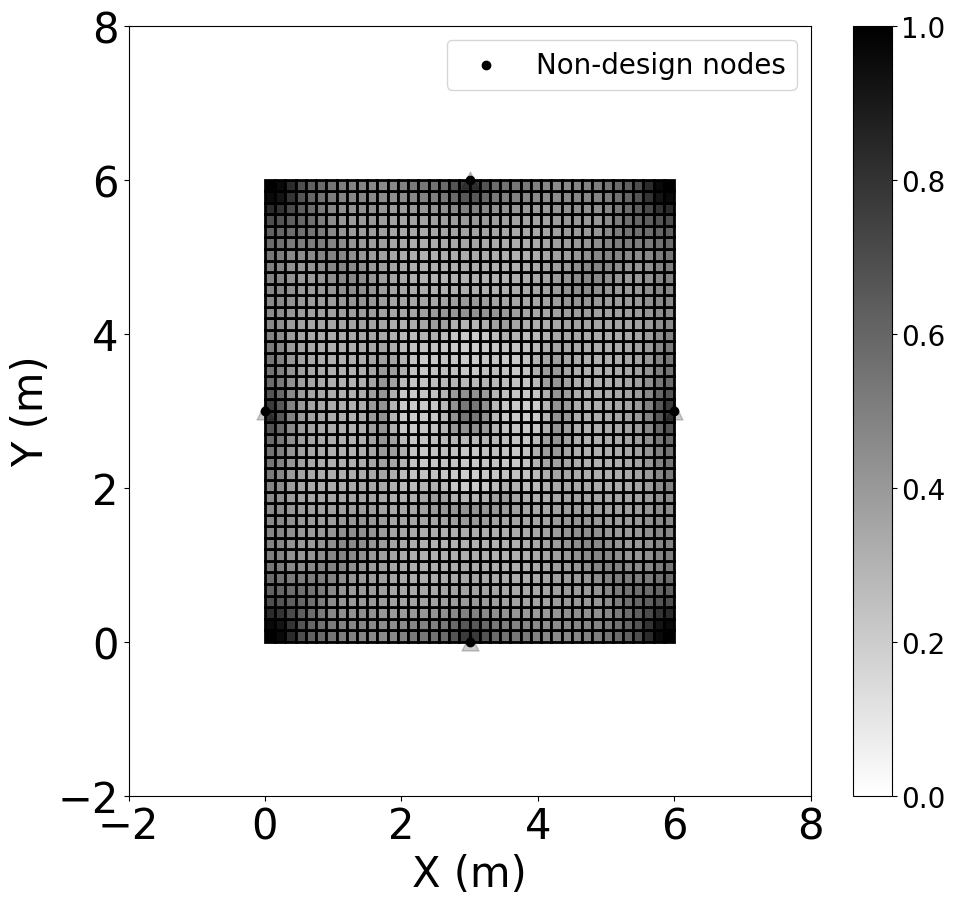

21th iteration, C = 69.28962425696801 
22th iteration, C = 20.912839283078142 
23th iteration, C = 15.435111124020715 
24th iteration, C = 15.748245349054585 
25th iteration, C = 12.509622339536179 
799.367457772614


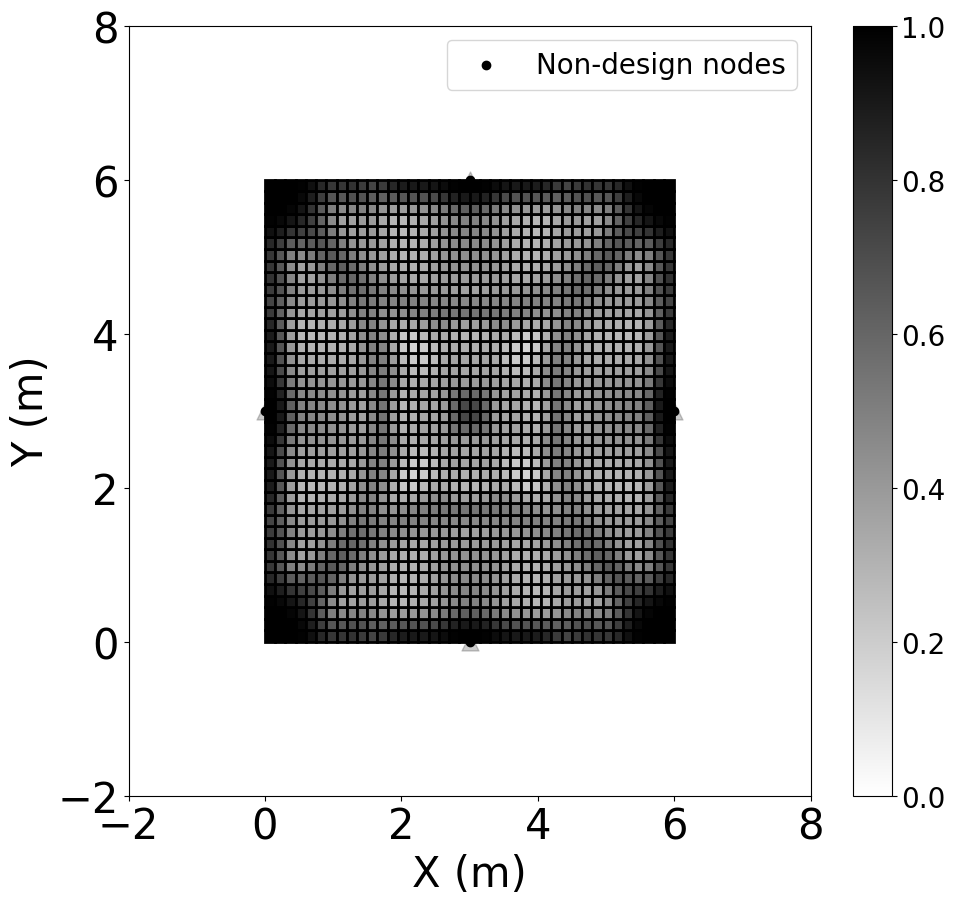

26th iteration, C = 10.848993737275228 
27th iteration, C = 10.020927038430687 
28th iteration, C = 6.846302468953225 
29th iteration, C = 3.9423540043044345 
30th iteration, C = 14.599038951135013 
790.1777595154724


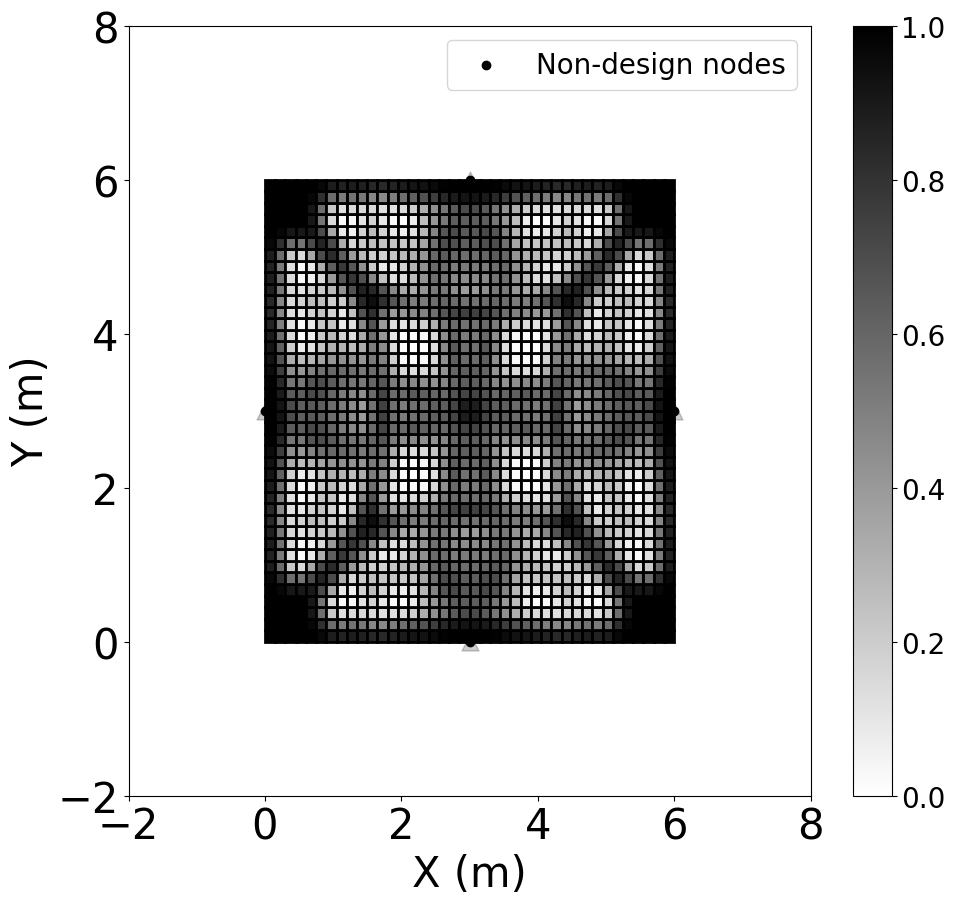

31th iteration, C = 3.495821186256566 
32th iteration, C = 3.3656010335094946 
33th iteration, C = 3.285213580982791 
34th iteration, C = 2.8856594387773193 
35th iteration, C = 11.326351720966693 
787.1241265249079


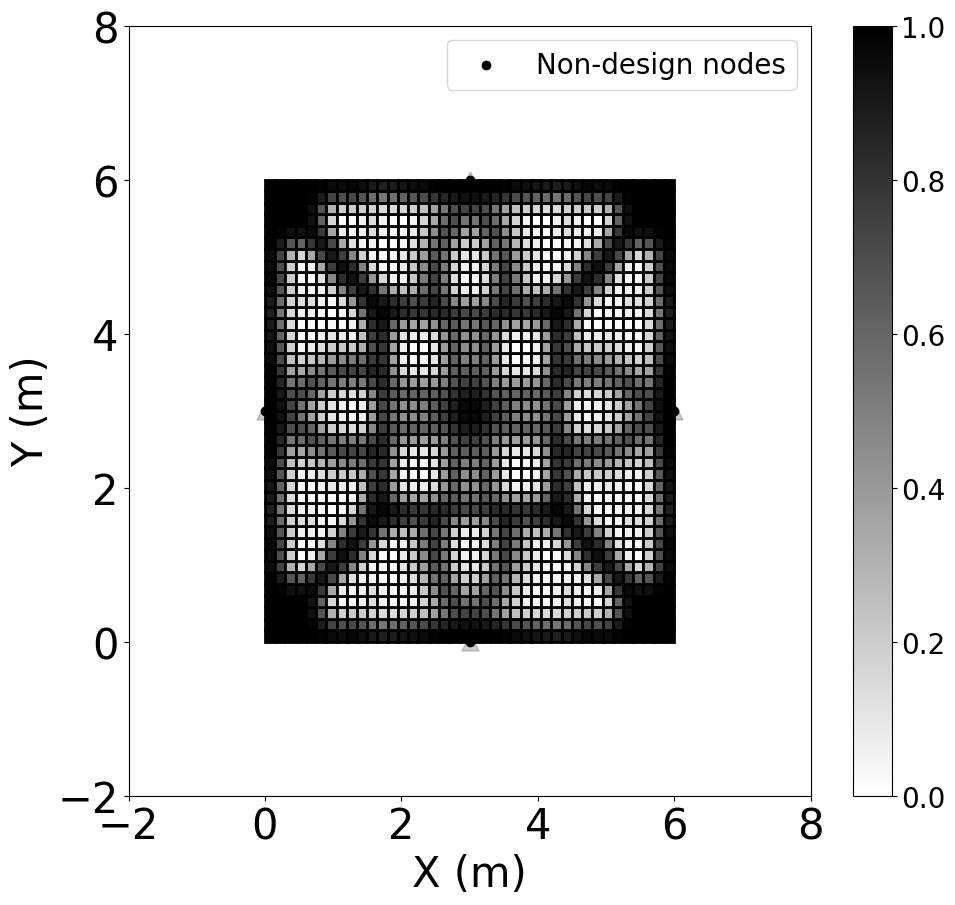

36th iteration, C = 4.819129952159741 
37th iteration, C = 2.807071421868551 
38th iteration, C = 2.7479907172157763 
39th iteration, C = 2.7140131651273176 
40th iteration, C = 2.5049142097402255 
798.9735185738547


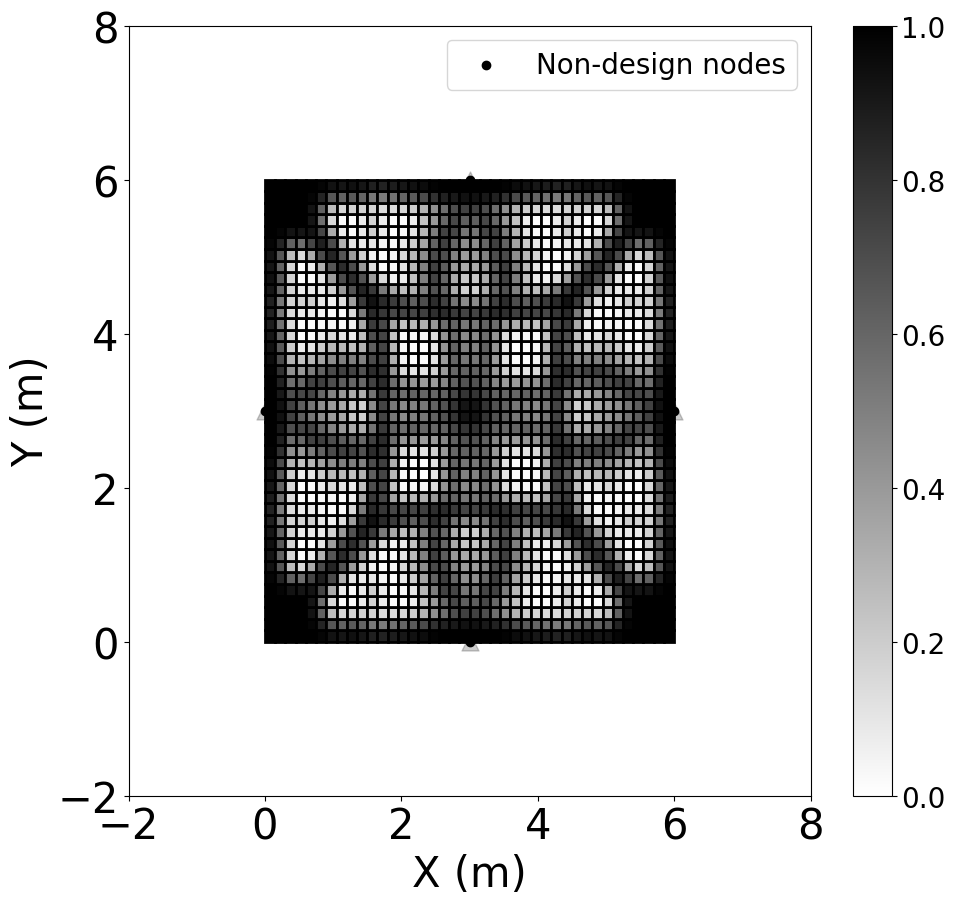

41th iteration, C = 6.8257244685901295 
42th iteration, C = 2.700563425546776 
43th iteration, C = 2.4526055820870263 
44th iteration, C = 2.4140071805247683 
45th iteration, C = 2.904504631474398 
797.538910386237


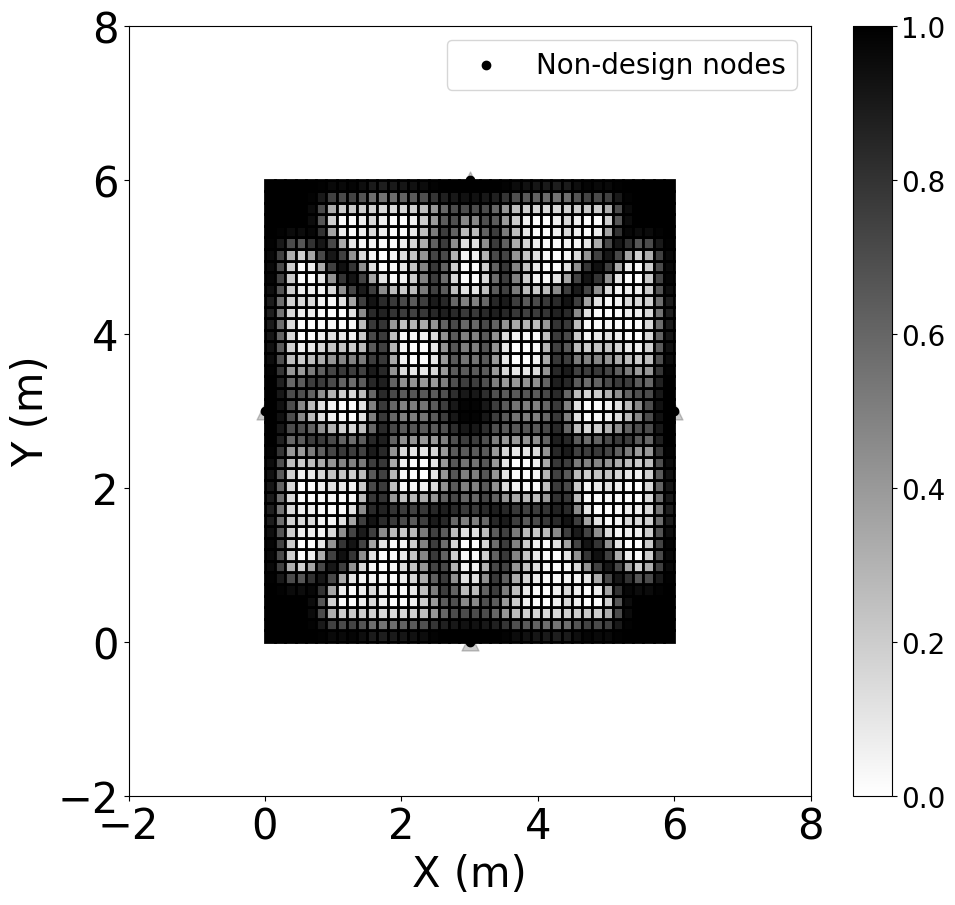

46th iteration, C = 2.365422438341037 
47th iteration, C = 2.3637906165930445 
48th iteration, C = 2.3074565999473315 
49th iteration, C = 2.2878578380137142 
50th iteration, C = 2.193041538517453 
799.5046069432467


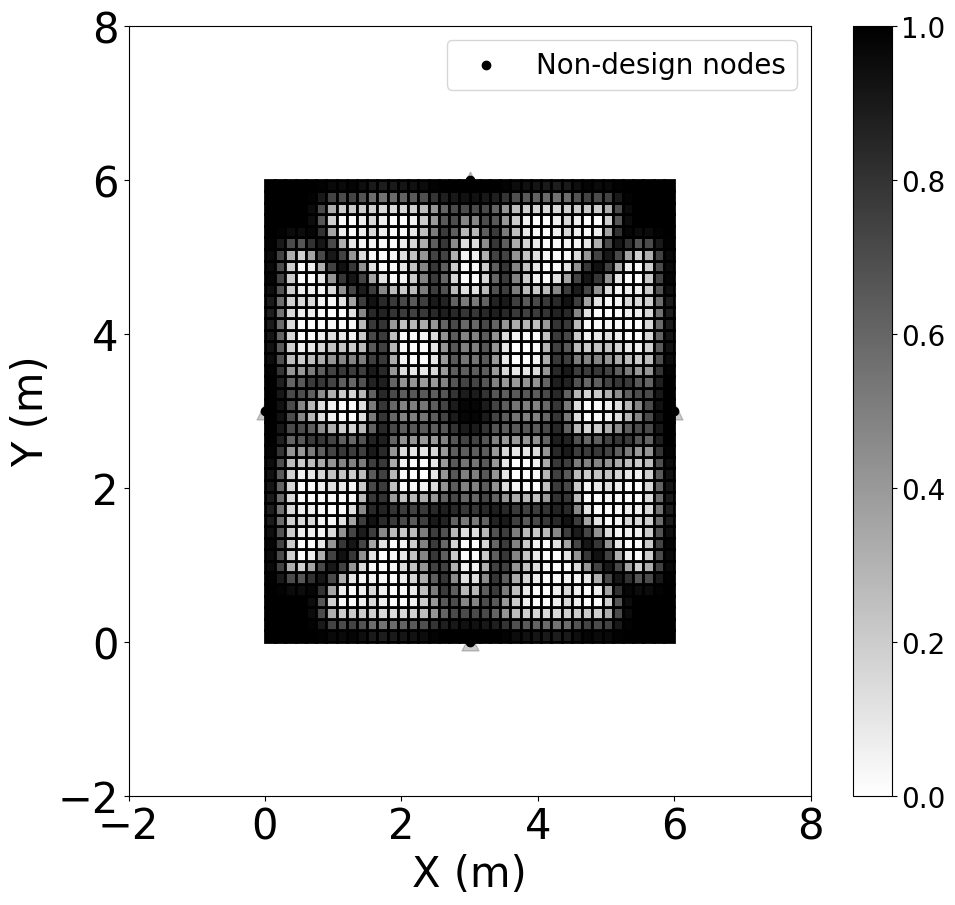

51th iteration, C = 2.0407253461783075 
52th iteration, C = 5.931119303881474 
53th iteration, C = 2.1922542955690503 
54th iteration, C = 1.9629024428548367 
55th iteration, C = 2.0192597315008314 
799.7045589125615


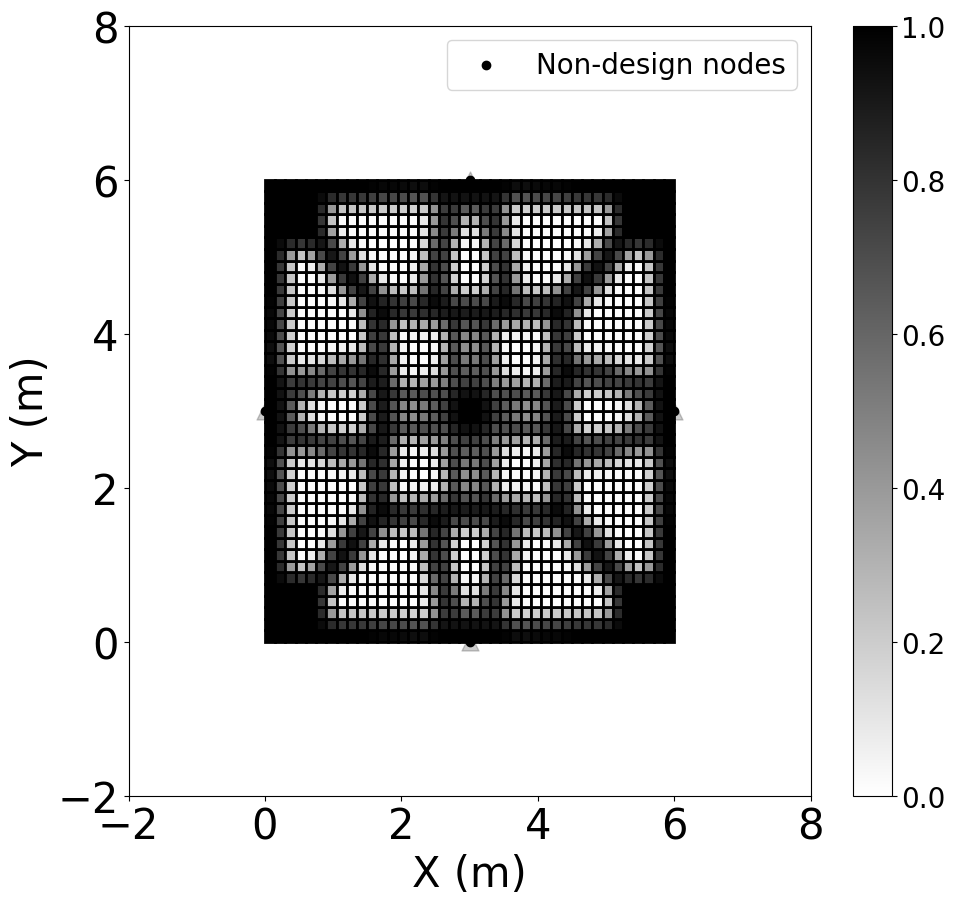

56th iteration, C = 1.9276205151865498 
57th iteration, C = 3.3670696039732184 
58th iteration, C = 1.9311982106124157 
59th iteration, C = 1.9161865532251587 
60th iteration, C = 1.8918718304033788 
799.7733371248391


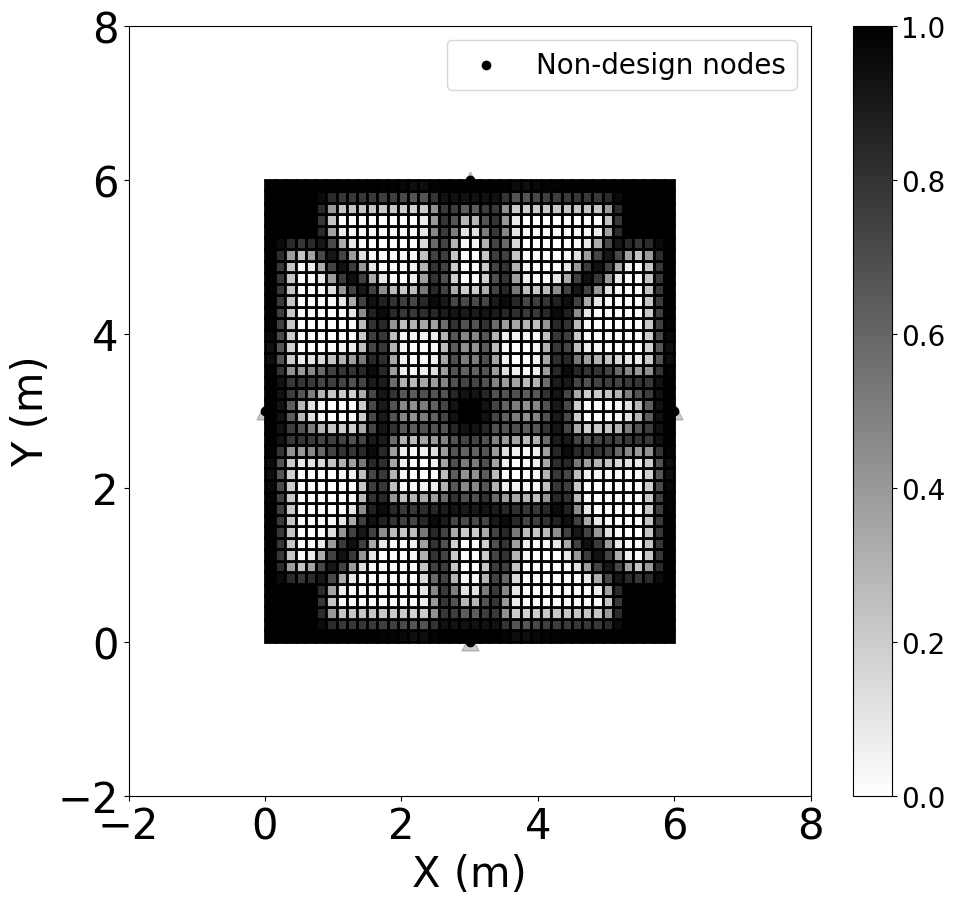

61th iteration, C = 2.4040245363044295 
62th iteration, C = 1.8917514245869533 
63th iteration, C = 1.9737111818691988 
64th iteration, C = 1.8786085126370804 
65th iteration, C = 1.8776125903146499 
799.9150950409132


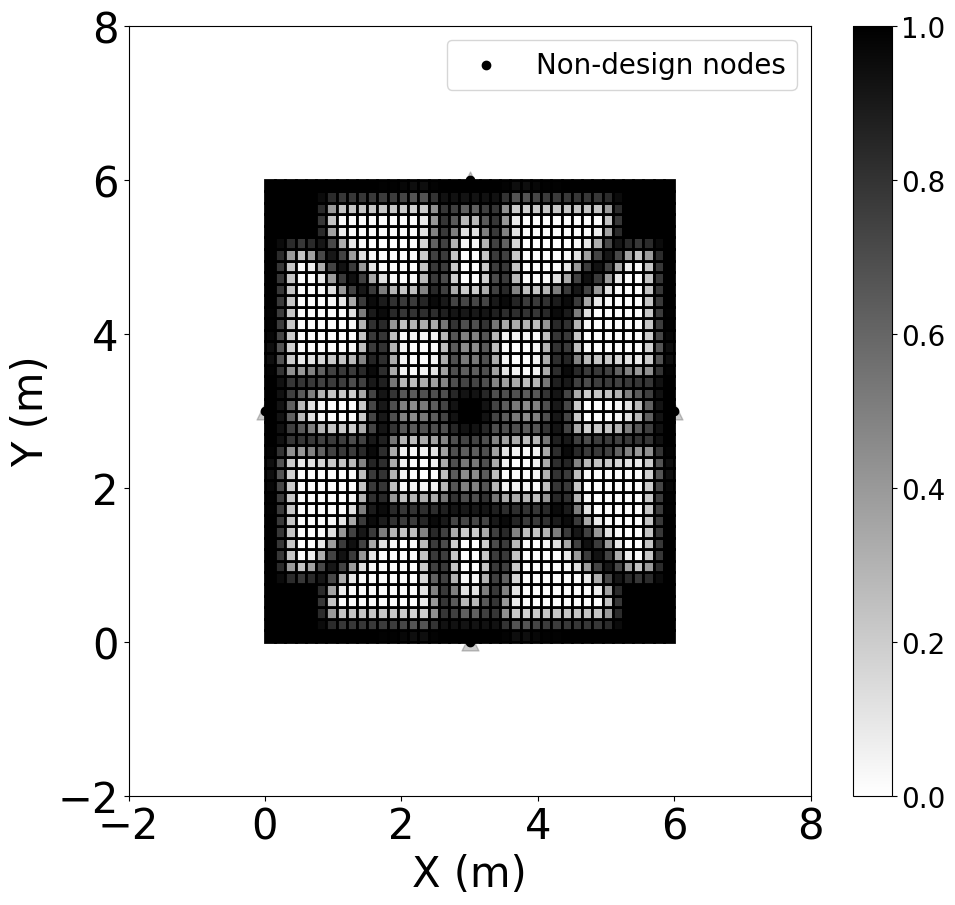

66th iteration, C = 1.9267236027426249 
67th iteration, C = 1.8612339595070682 
68th iteration, C = 1.8584564281717824 
69th iteration, C = 1.8486986367890956 
70th iteration, C = 5.326499410723842 
799.3371501322288


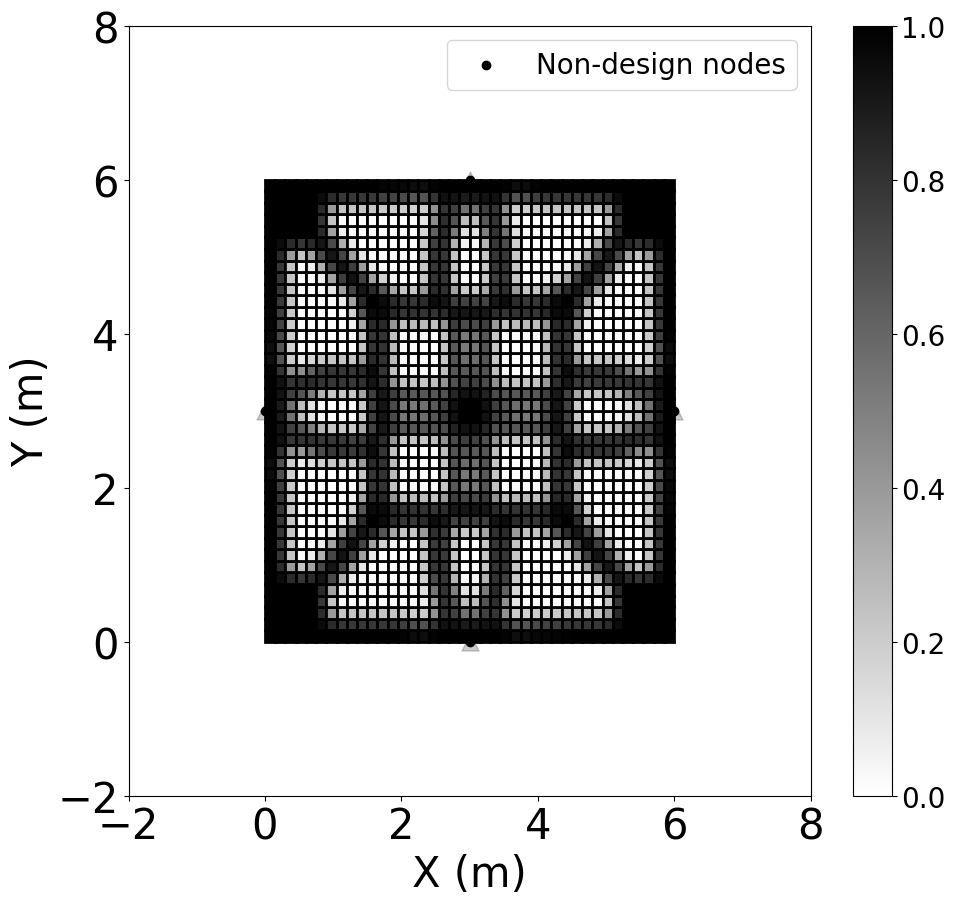

71th iteration, C = 1.9137095574716707 
72th iteration, C = 1.8414151481401633 
73th iteration, C = 1.8631615980195981 
74th iteration, C = 1.834236673446071 
75th iteration, C = 1.842400478180431 
799.9697986274223


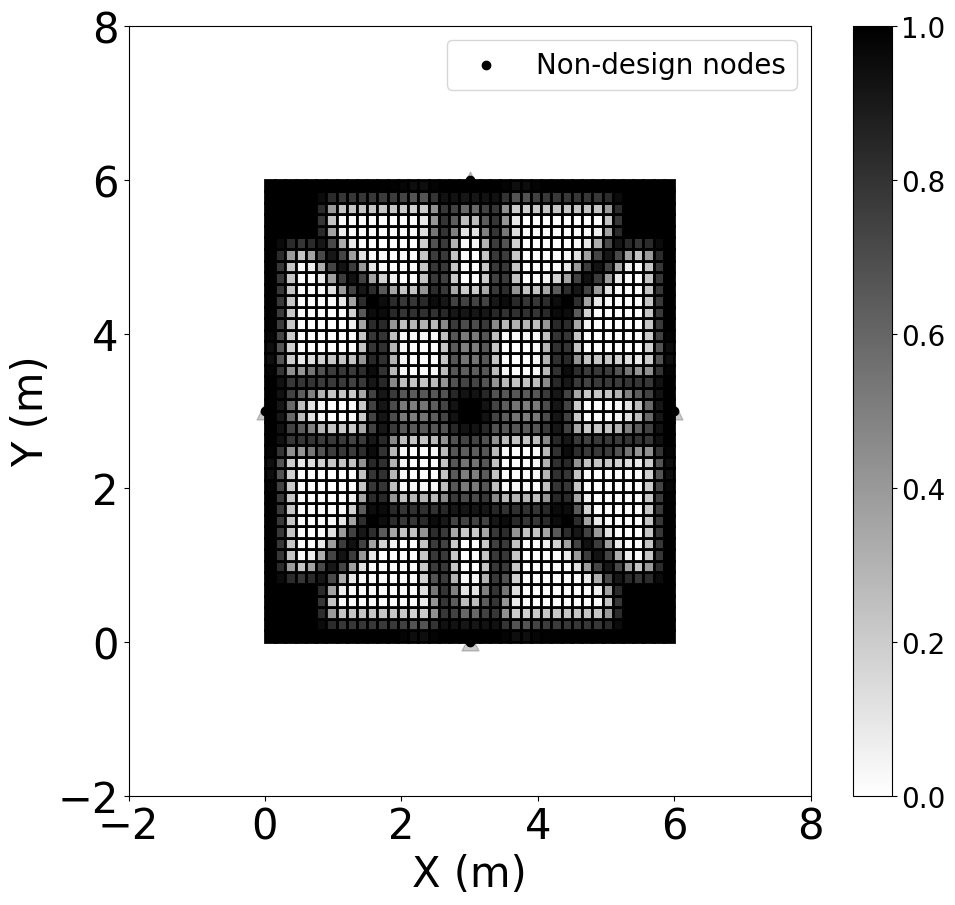

76th iteration, C = 1.828195169118823 
77th iteration, C = 1.812302927419641 
78th iteration, C = 6.034449189379726 
79th iteration, C = 2.08211175126774 
80th iteration, C = 1.8059724936090644 
799.9973614549649


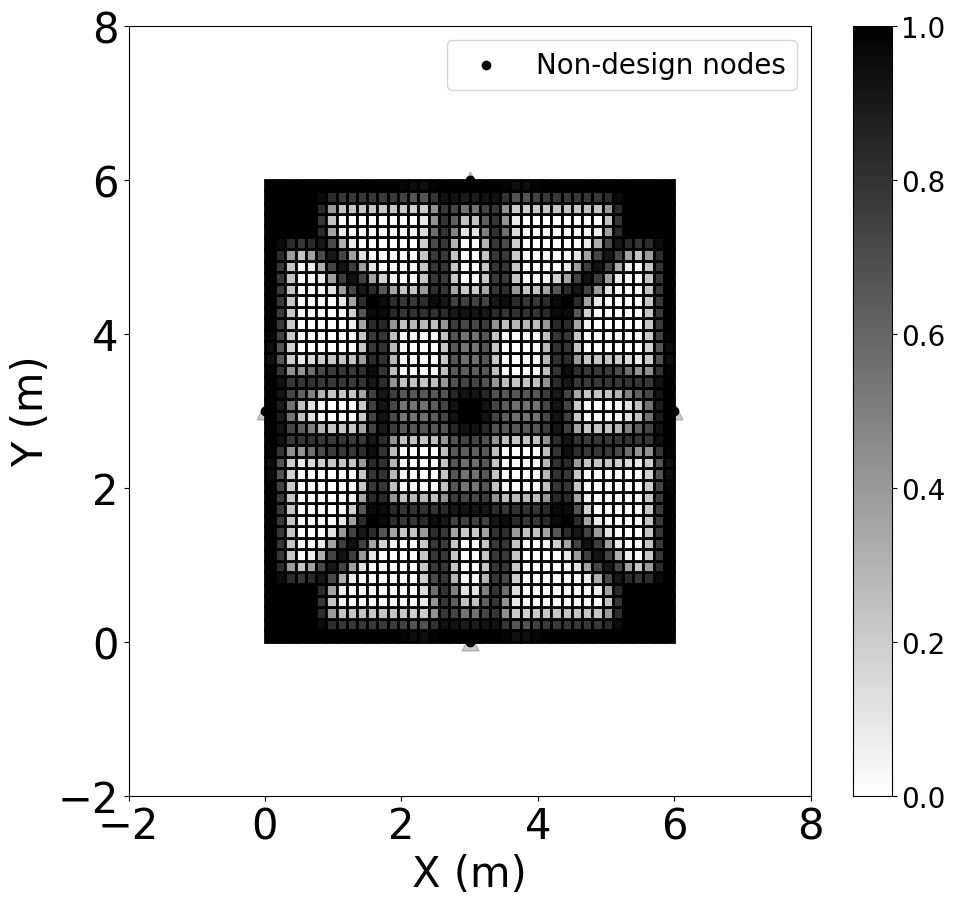

81th iteration, C = 1.8033667545317278 
82th iteration, C = 1.7921927449126993 
83th iteration, C = 1.9942177340986103 
84th iteration, C = 1.7846378426324414 
85th iteration, C = 1.78281664008768 
799.999407035695


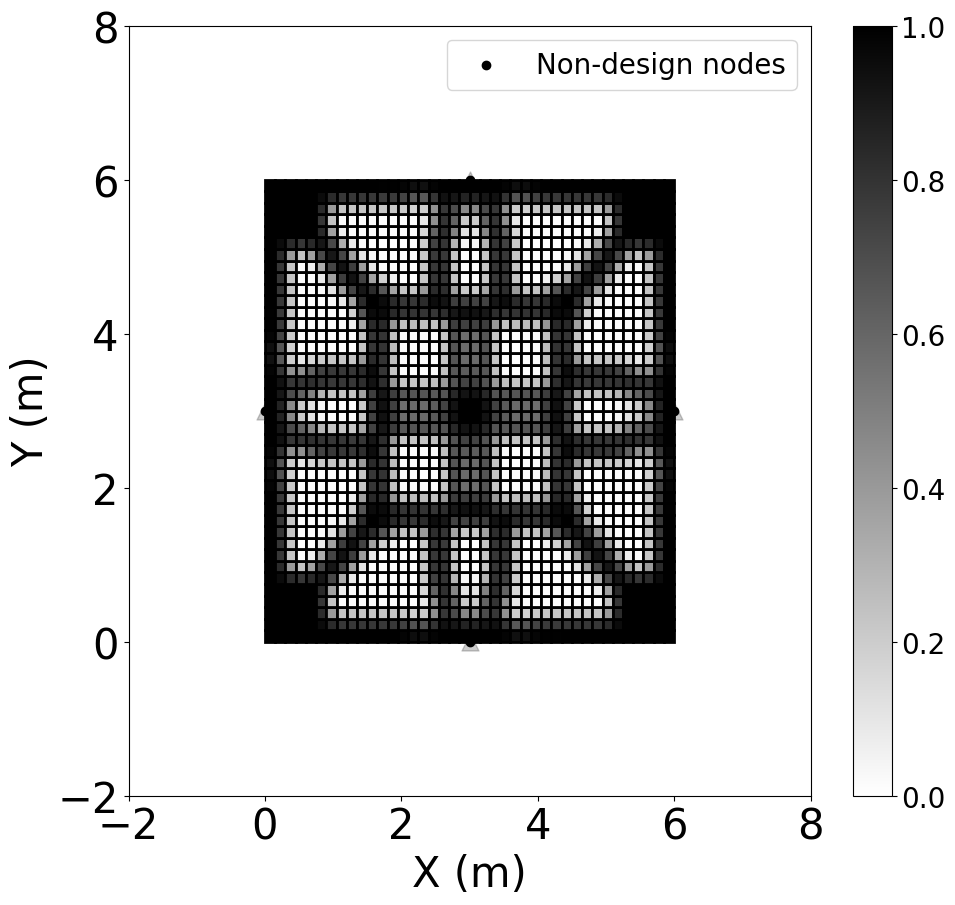

86th iteration, C = 1.7736106914347958 
87th iteration, C = 2.447672284895665 
88th iteration, C = 1.7924168883283806 
89th iteration, C = 1.7710803333649012 
90th iteration, C = 1.769001031334817 
799.997617809272


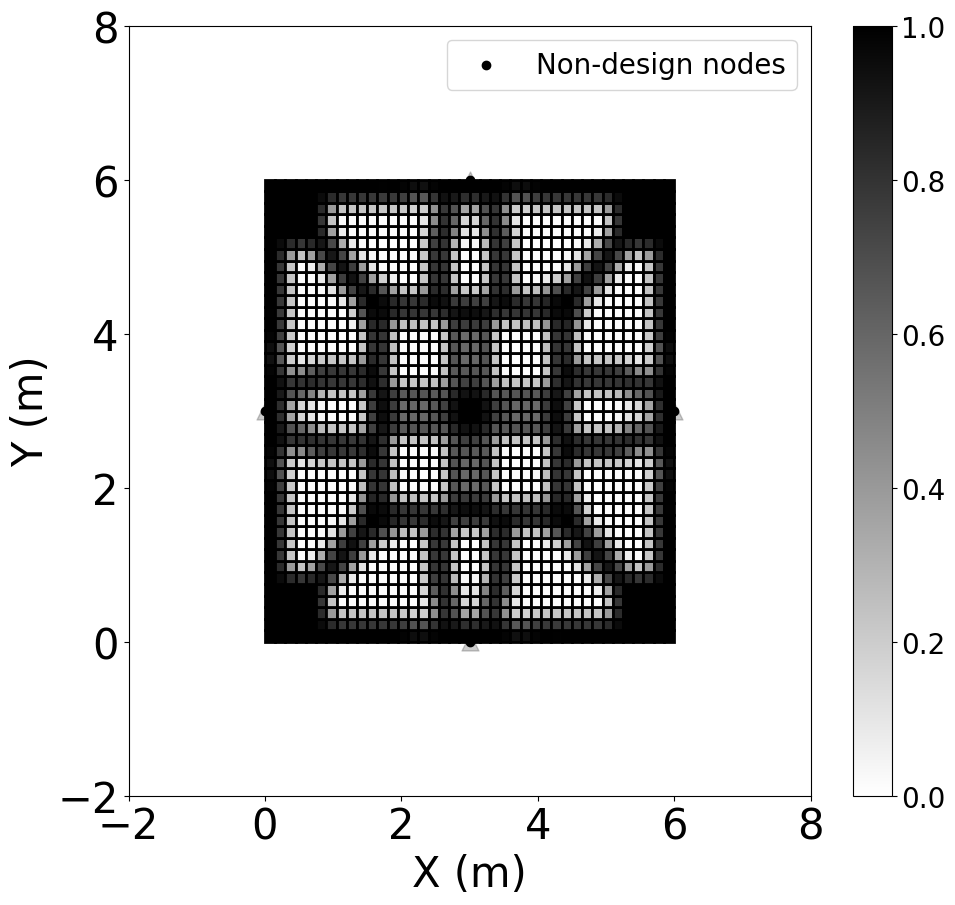

91th iteration, C = 1.7885227578699197 
92th iteration, C = 1.7663435945705872 
93th iteration, C = 1.7709278949795186 
94th iteration, C = 1.7638297251165622 
95th iteration, C = 1.7551023450111438 
799.9680555631448


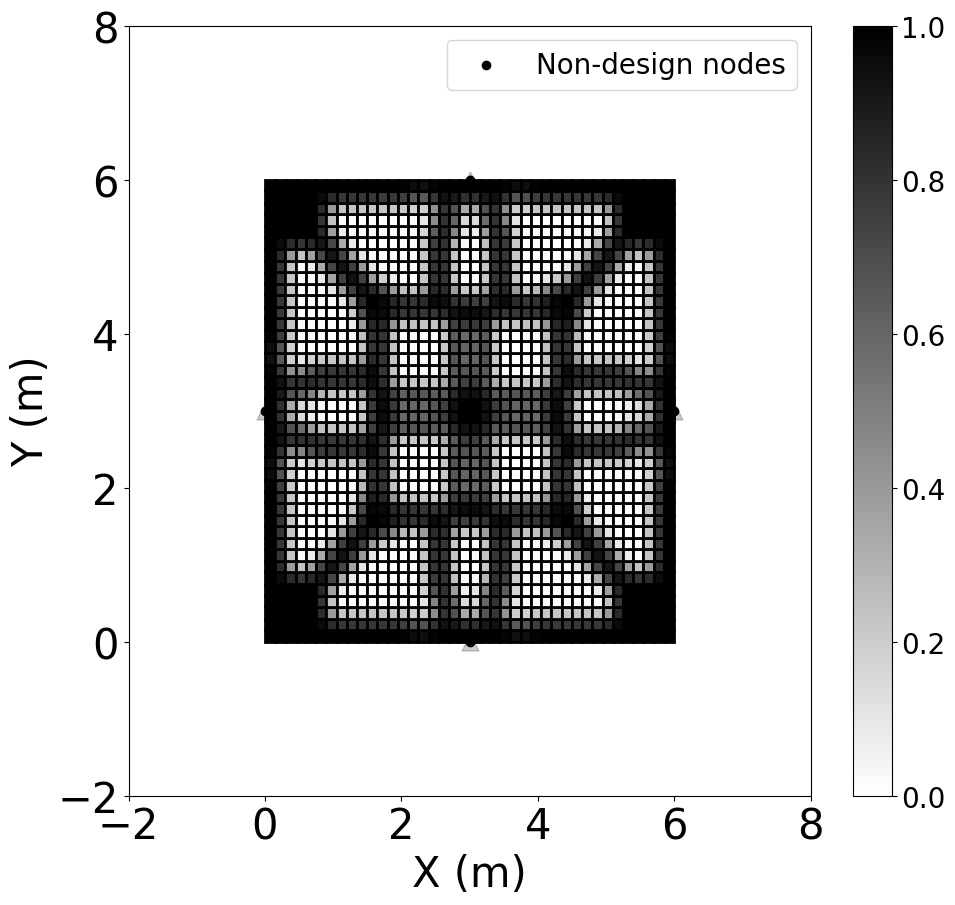

96th iteration, C = 4.74594487086641 
97th iteration, C = 2.0347157572254537 
98th iteration, C = 1.7529852348567199 
99th iteration, C = 1.7511764222732347 
100th iteration, C = 1.7431843547503518 
799.9807080593916


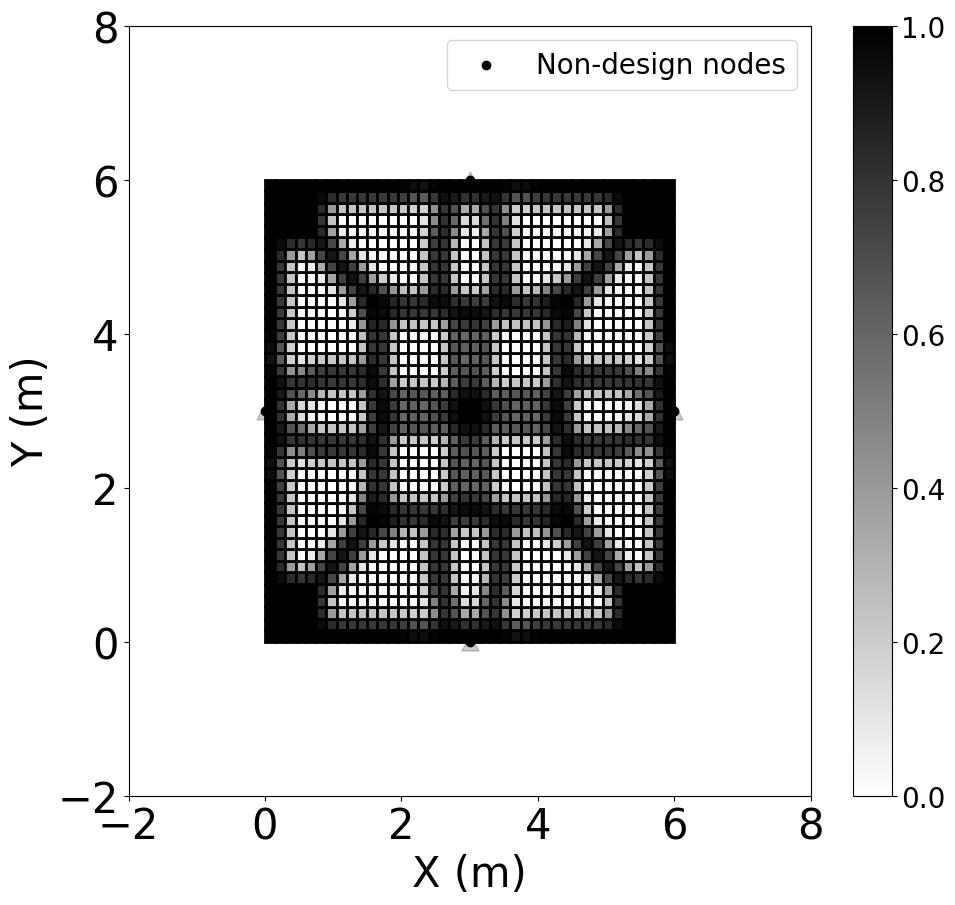

101th iteration, C = 3.714359043528365 
102th iteration, C = 1.8504416636334313 
103th iteration, C = 1.7401144959137438 
104th iteration, C = 1.7268202570934847 
105th iteration, C = 2.472281846812066 
799.1938562585426


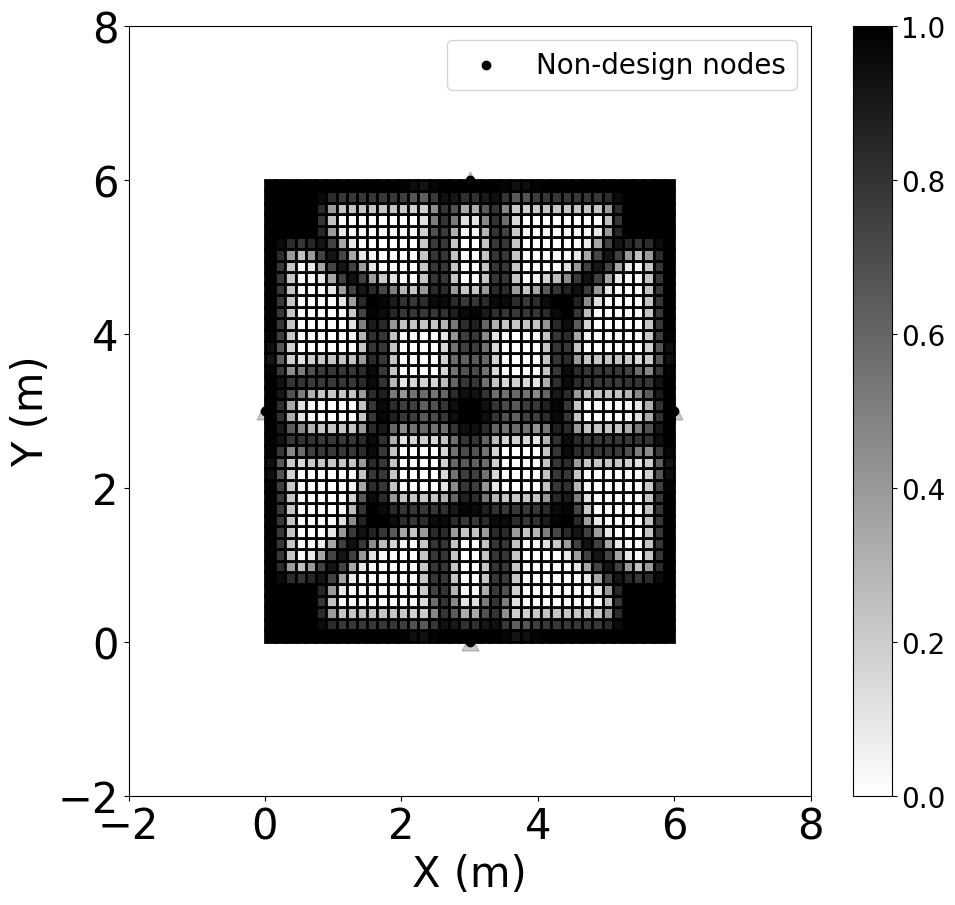

106th iteration, C = 1.763353143843773 
107th iteration, C = 1.7220692665676112 
108th iteration, C = 1.7535703913132867 
109th iteration, C = 1.7167890999541346 
110th iteration, C = 1.7254544147177056 
799.9888618650931


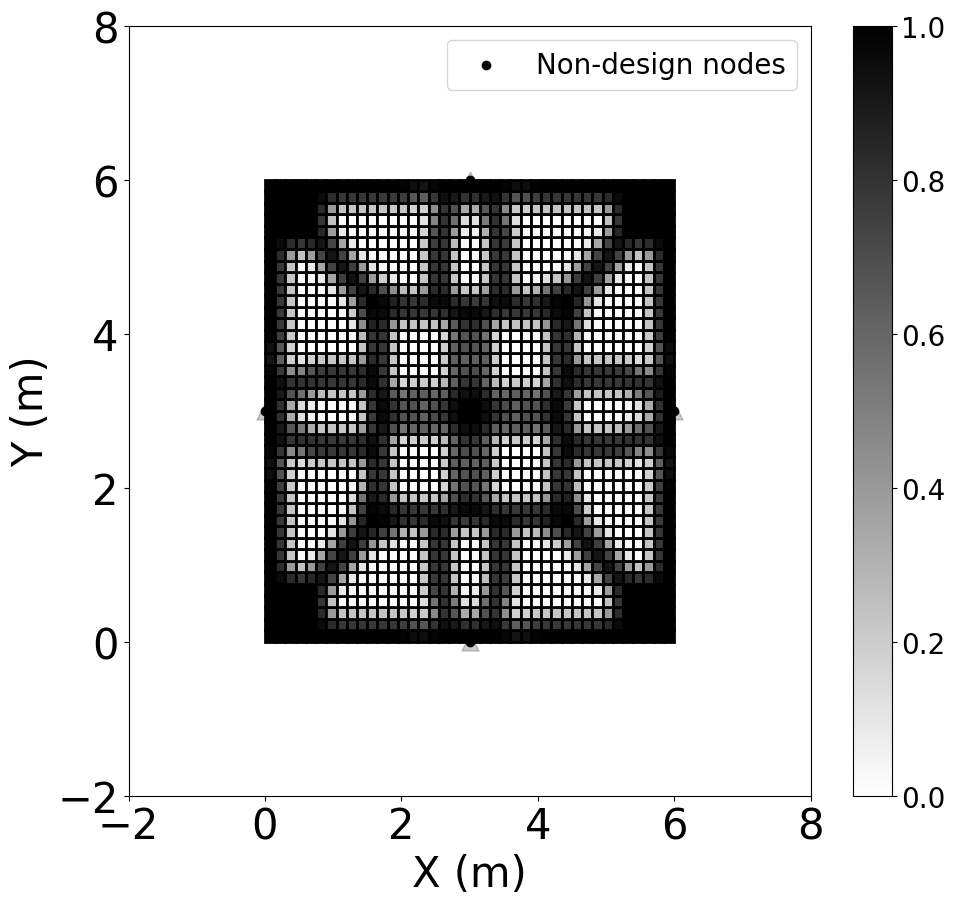

111th iteration, C = 1.7123360134032424 
112th iteration, C = 1.705463031802738 
113th iteration, C = 1.8569081104860026 
114th iteration, C = 1.69840098909492 
115th iteration, C = 1.6924867214797408 
799.9000464637875


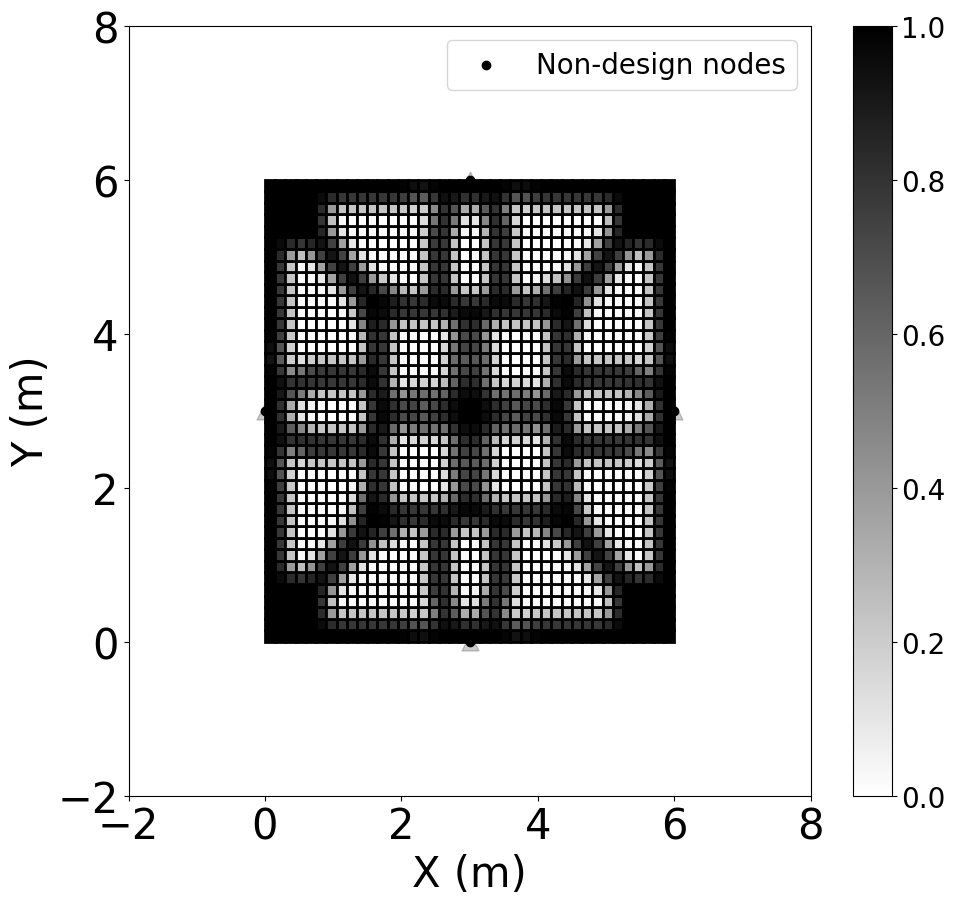

116th iteration, C = 1.8667359429438186 
117th iteration, C = 1.6864342560536507 
118th iteration, C = 1.6843101428572378 
119th iteration, C = 1.6790257033616318 
120th iteration, C = 1.702881566746836 
799.9662279588192


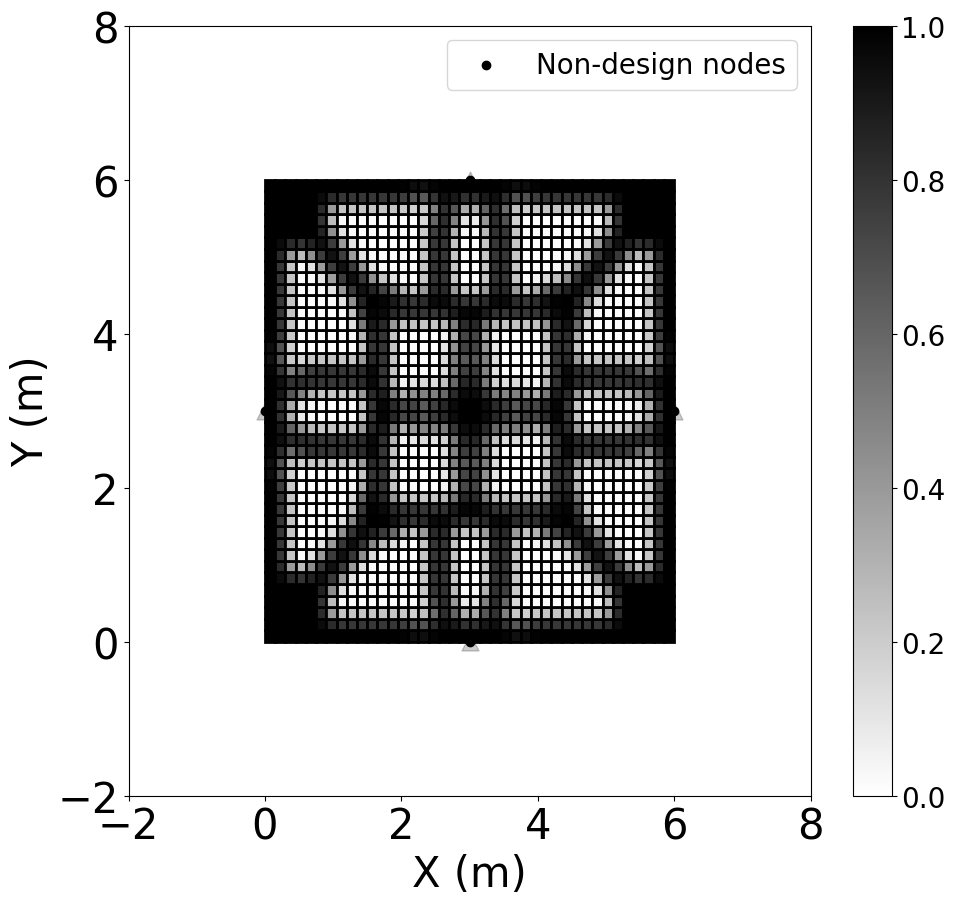

121th iteration, C = 1.6746433275098167 
122th iteration, C = 1.6667431961599468 
123th iteration, C = 4.009818622343958 
124th iteration, C = 1.8851517170616736 
125th iteration, C = 1.6639066804345355 
799.9975735575933


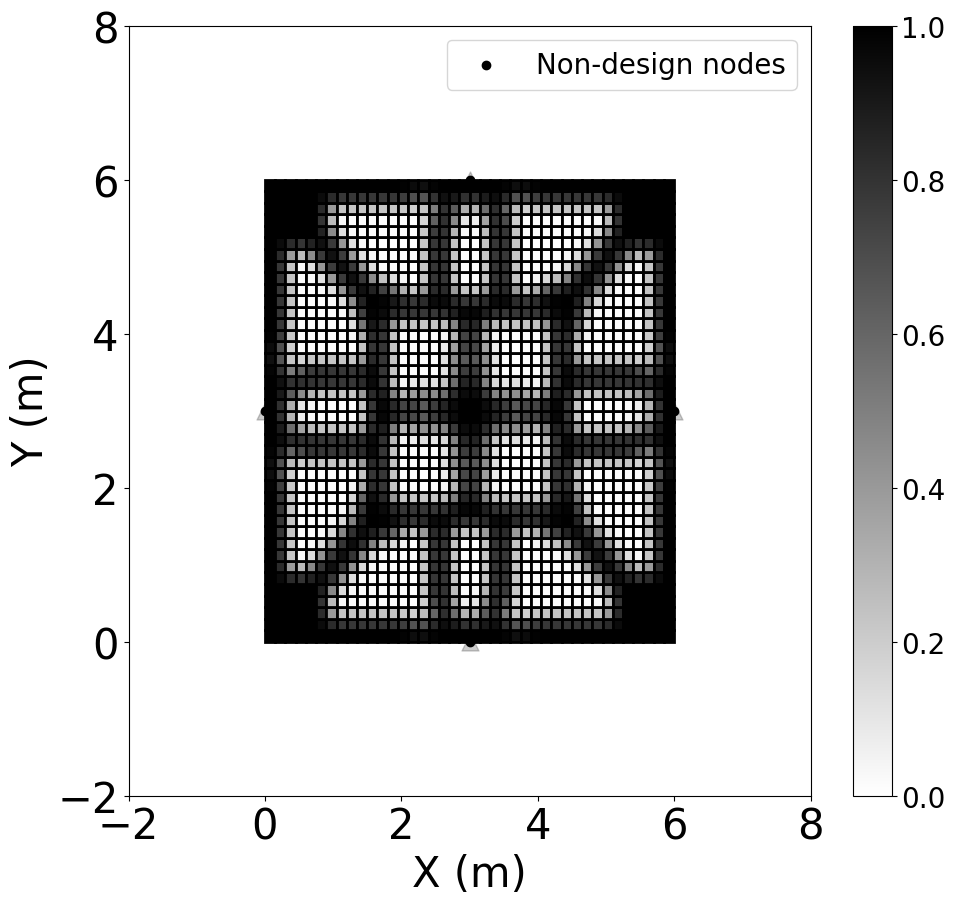

126th iteration, C = 1.662302743033251 
127th iteration, C = 1.6585156796145522 
128th iteration, C = 1.7634784296317083 
129th iteration, C = 1.654159940354646 
130th iteration, C = 1.6463572712700902 
799.9022612503596


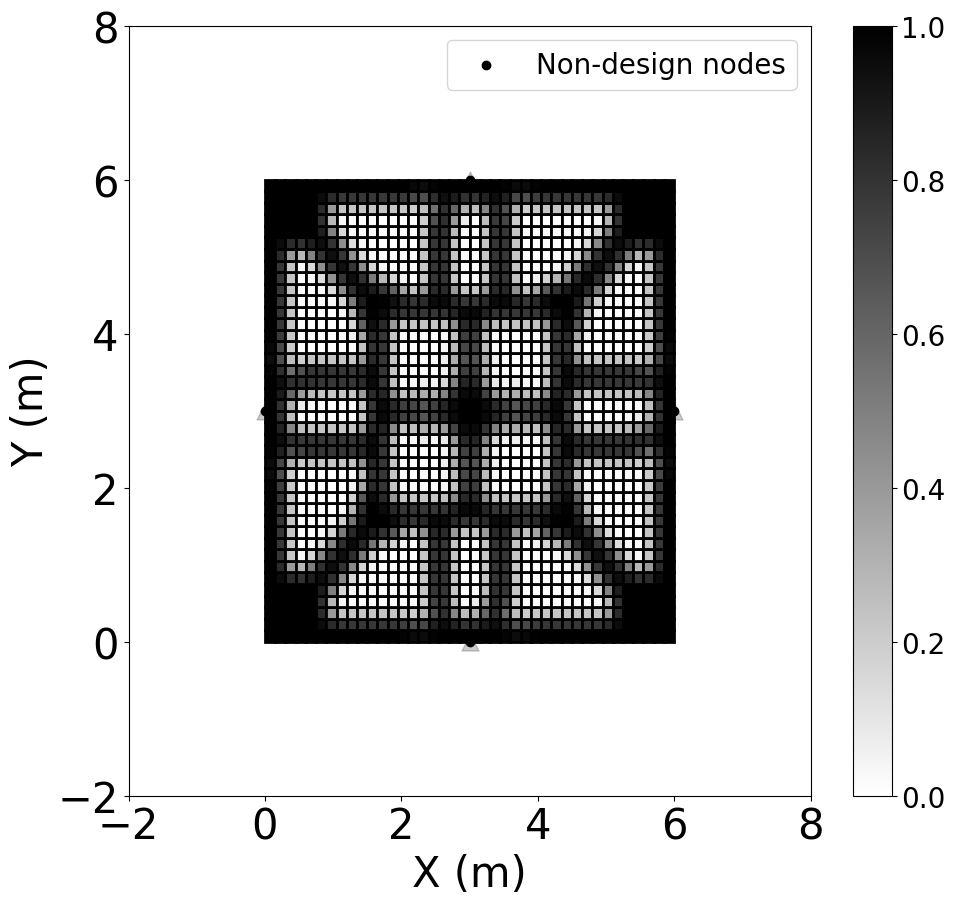

131th iteration, C = 2.1911477037076534 
132th iteration, C = 1.664919370242023 
133th iteration, C = 1.6441585919836688 
134th iteration, C = 1.6427339309818874 
135th iteration, C = 1.6497150702321304 
799.8290865936394


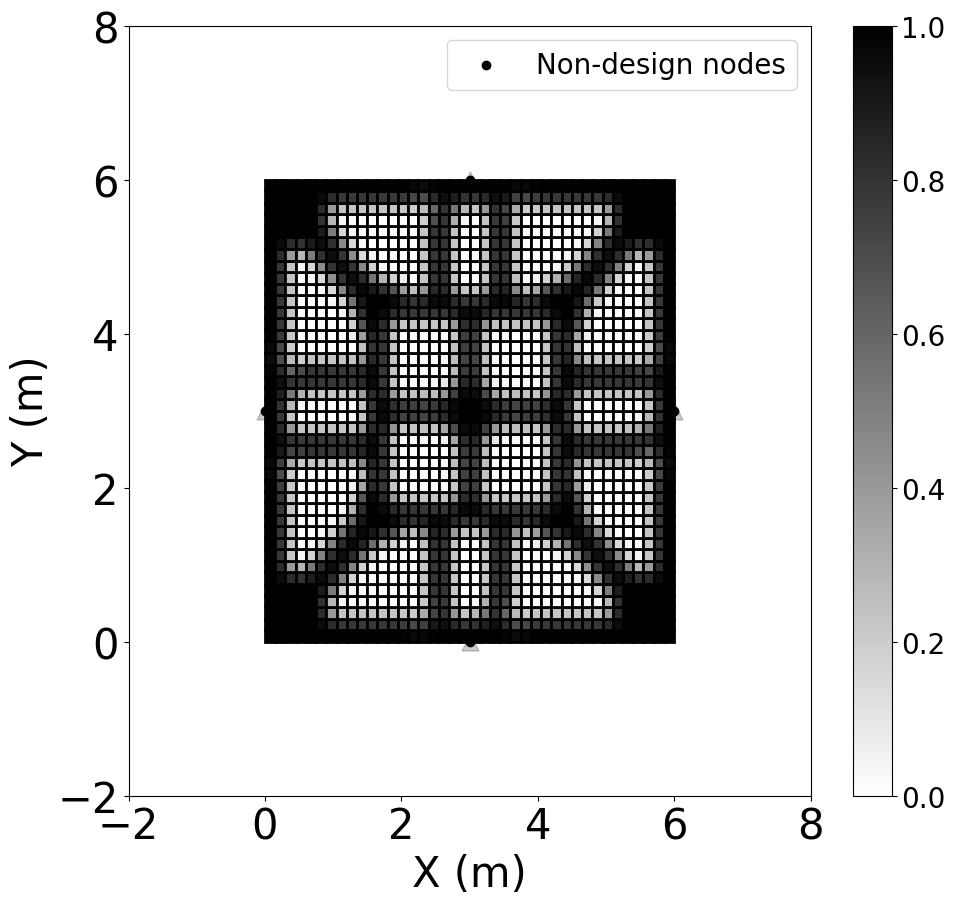

136th iteration, C = 1.640360175830902 
137th iteration, C = 2.1518687985741507 
138th iteration, C = 1.6442543794736408 
139th iteration, C = 1.6387853841420392 
140th iteration, C = 1.6332726041399308 
799.8747154234317


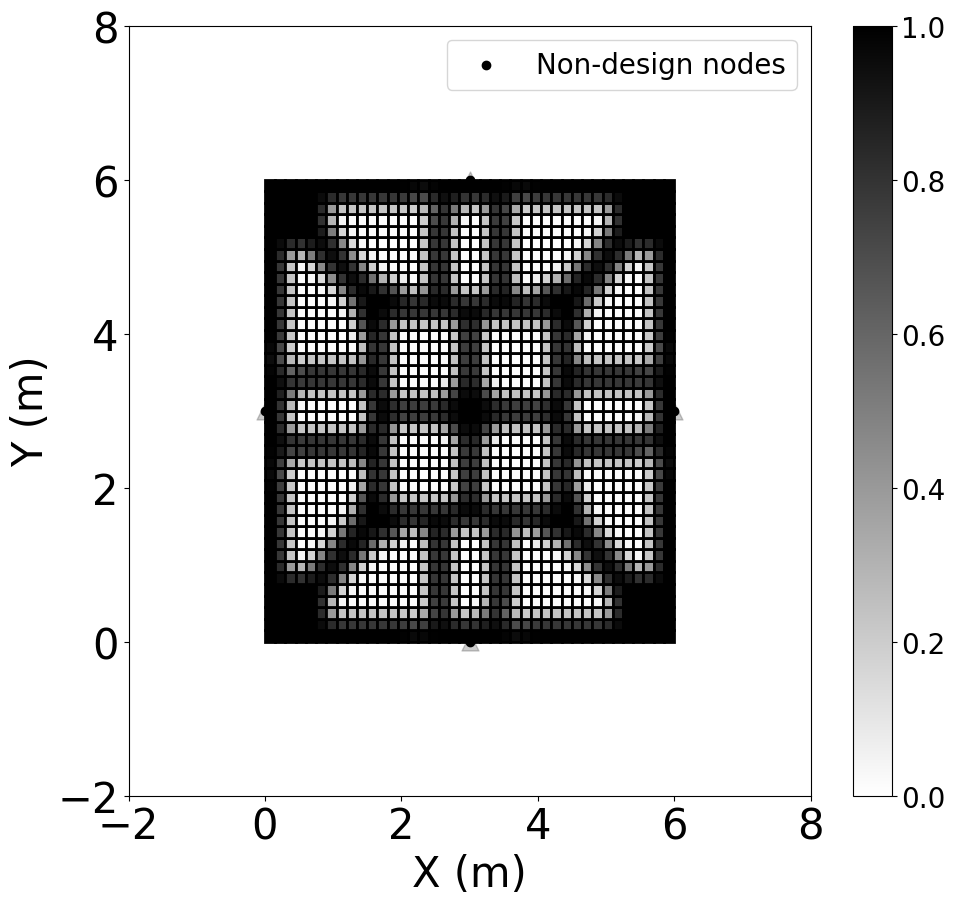

141th iteration, C = 2.8866055967532356 
142th iteration, C = 1.6744526445517054 
143th iteration, C = 1.6302587239840967 
144th iteration, C = 1.628283617001969 
145th iteration, C = 1.6710736482648496 
799.9879269135919


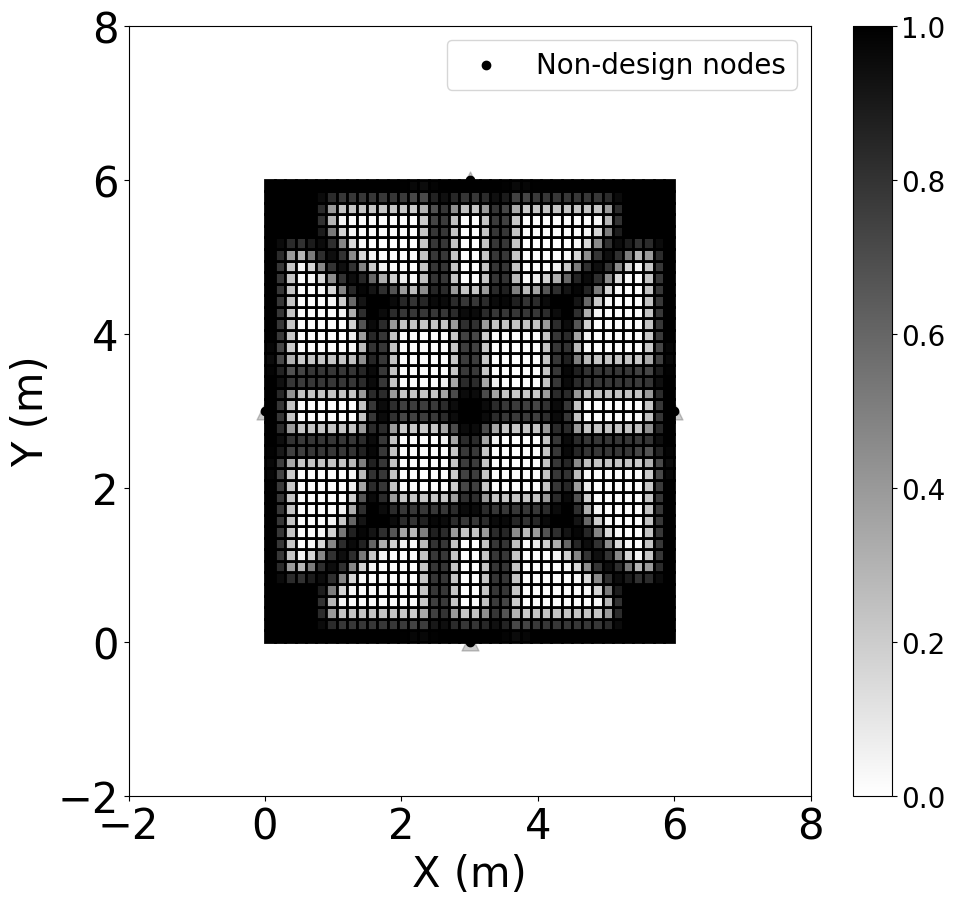

146th iteration, C = 1.6260391440807078 
147th iteration, C = 1.6257192219584728 
148th iteration, C = 1.6419690923924597 
149th iteration, C = 1.6239850648288696 
150th iteration, C = 1.6240045246165862 
799.993417122315


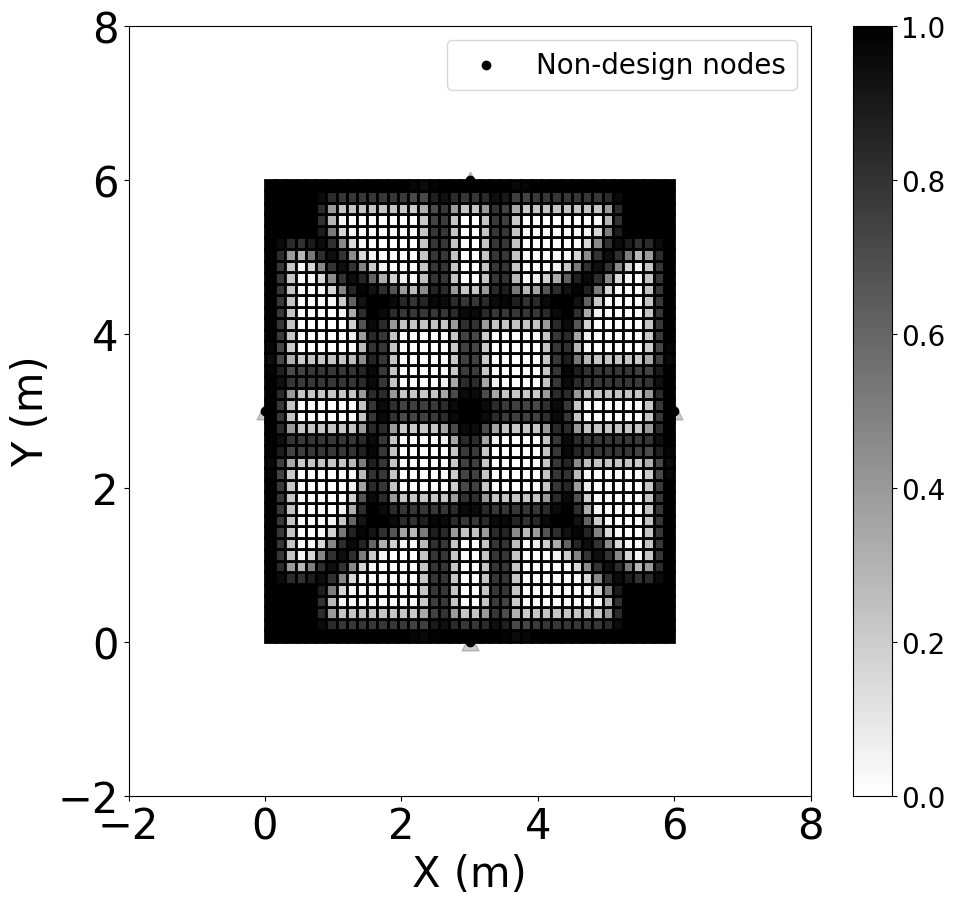

151th iteration, C = 1.6231669588214146 
152th iteration, C = 1.6233850300601895 
153th iteration, C = 1.6227080603757533 
154th iteration, C = 1.6224789239150075 
155th iteration, C = 1.6208021692873955 
799.9961665594703


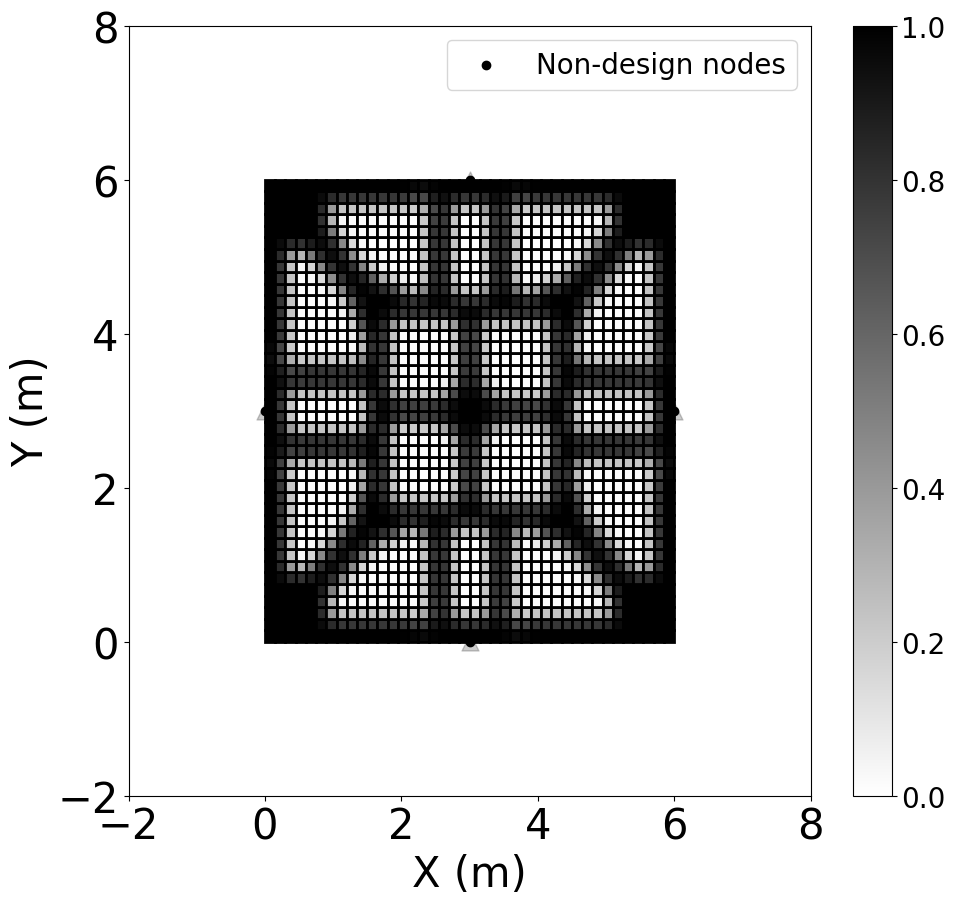

156th iteration, C = 1.8512728323897942 
157th iteration, C = 1.6298839434161874 
158th iteration, C = 1.6202887951273421 
159th iteration, C = 1.619902124954961 
160th iteration, C = 1.6224653309362276 
799.9944817124781


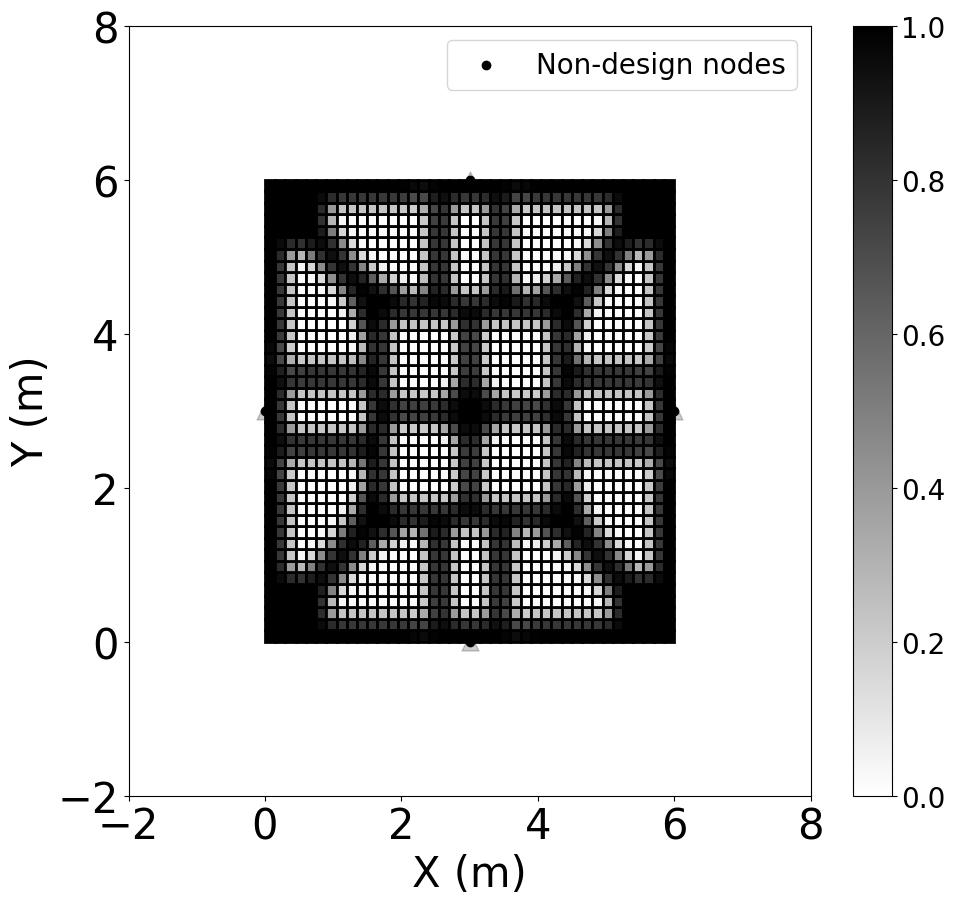

161th iteration, C = 1.6192216639836992 
162th iteration, C = 1.6235846102331948 
163th iteration, C = 1.6185886721269225 
164th iteration, C = 1.6172222703421832 
165th iteration, C = 1.6614426610006343 
799.9964456497632


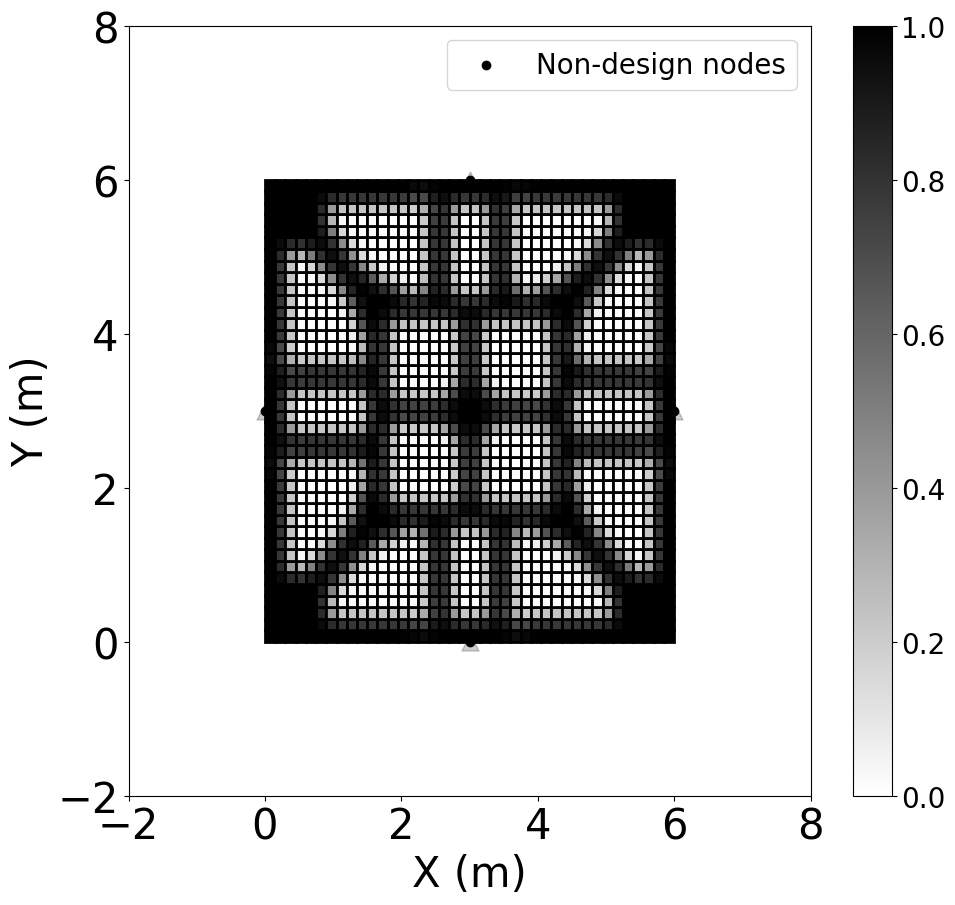

166th iteration, C = 1.616027429729899 
167th iteration, C = 1.6157780945859455 
168th iteration, C = 1.6143712891587167 
169th iteration, C = 1.76849544613209 
170th iteration, C = 1.6160314399327125 
799.9984727317205


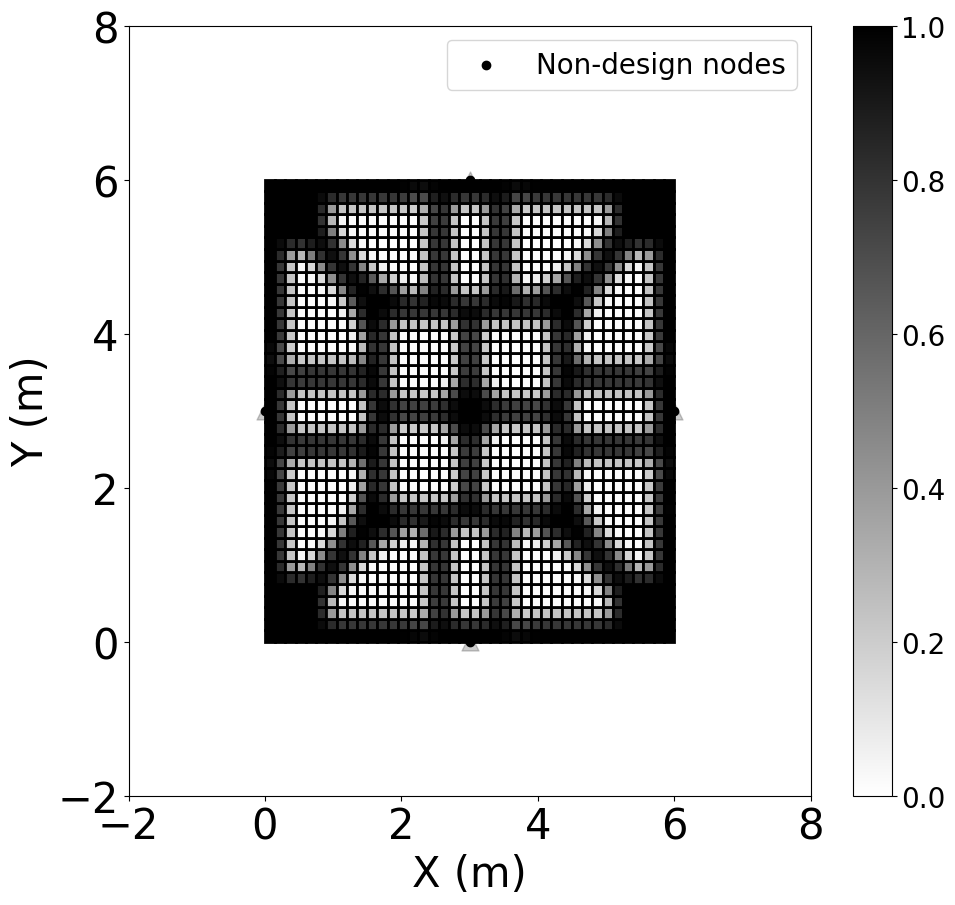

171th iteration, C = 1.6139147501980593 
172th iteration, C = 1.6279892586758382 
173th iteration, C = 1.613404832854405 
174th iteration, C = 1.6130964196541835 
175th iteration, C = 1.612433879089222 
799.9999298348969


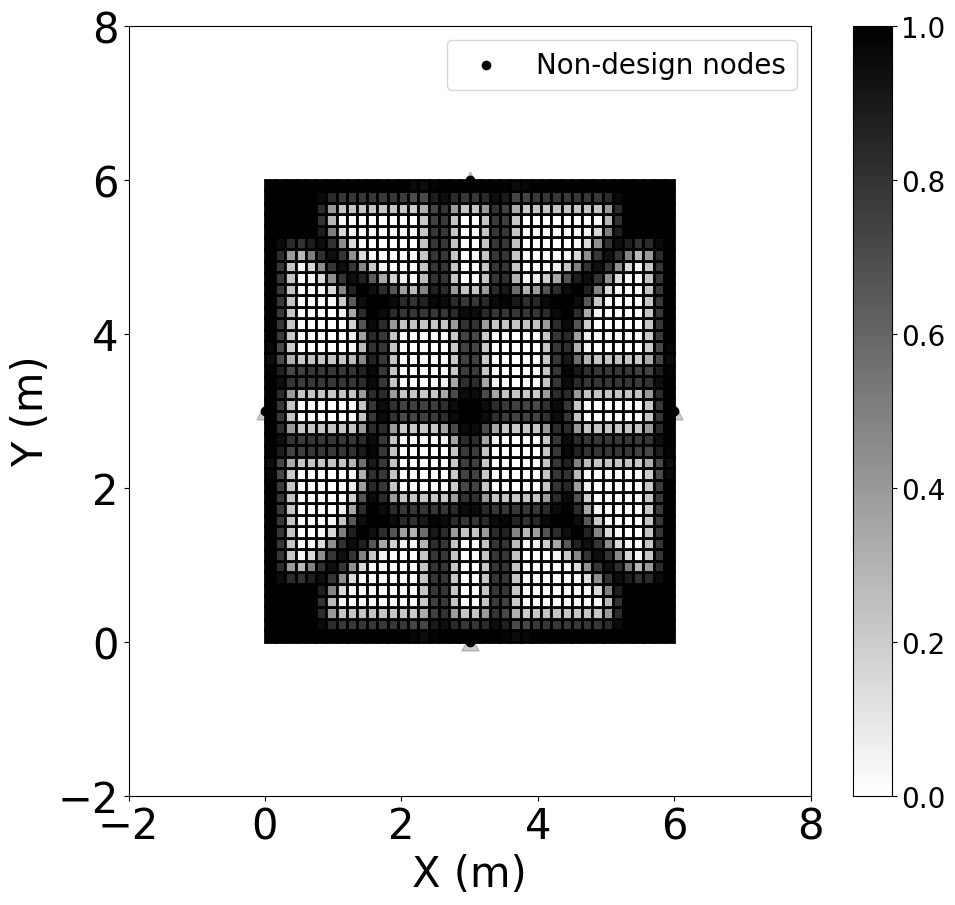

176th iteration, C = 1.6121566934501268 
177th iteration, C = 1.610538708149579 
178th iteration, C = 2.070374438212959 
179th iteration, C = 1.6325942574750099 
180th iteration, C = 1.6100102252758635 
799.9999509573611


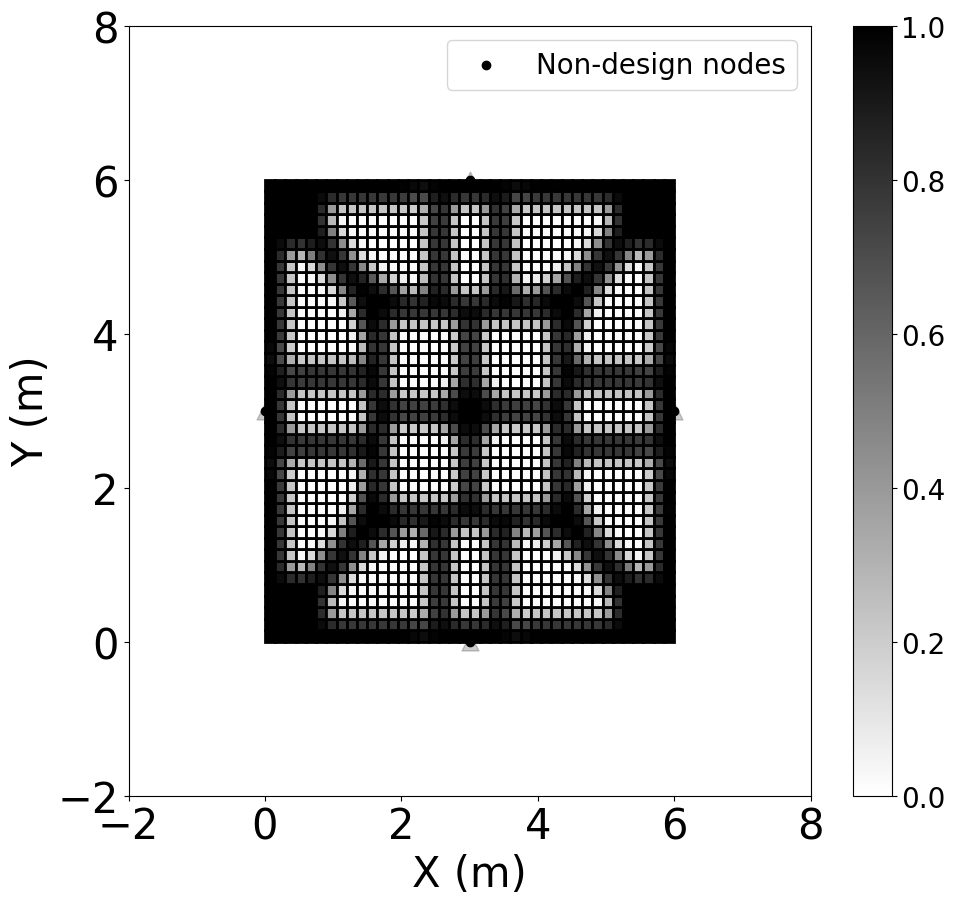

181th iteration, C = 1.6093053040576364 
182th iteration, C = 1.6379292273532786 
183th iteration, C = 1.6078357924267344 
184th iteration, C = 1.6068390837406454 
185th iteration, C = 1.6296102365659313 
799.9982997698754


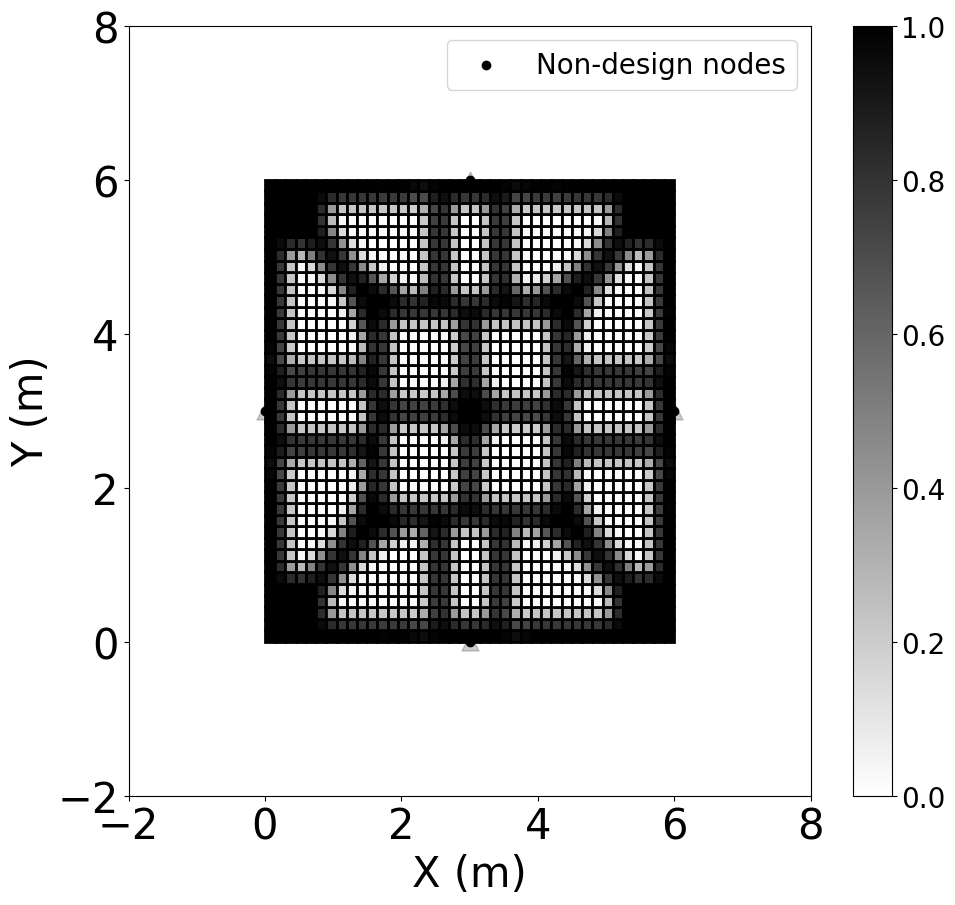

186th iteration, C = 1.6062124208972763 
187th iteration, C = 1.6061225238085282 
188th iteration, C = 1.631540563273742 
189th iteration, C = 1.6050088548868646 
190th iteration, C = 1.6047797334646423 
799.999996070238


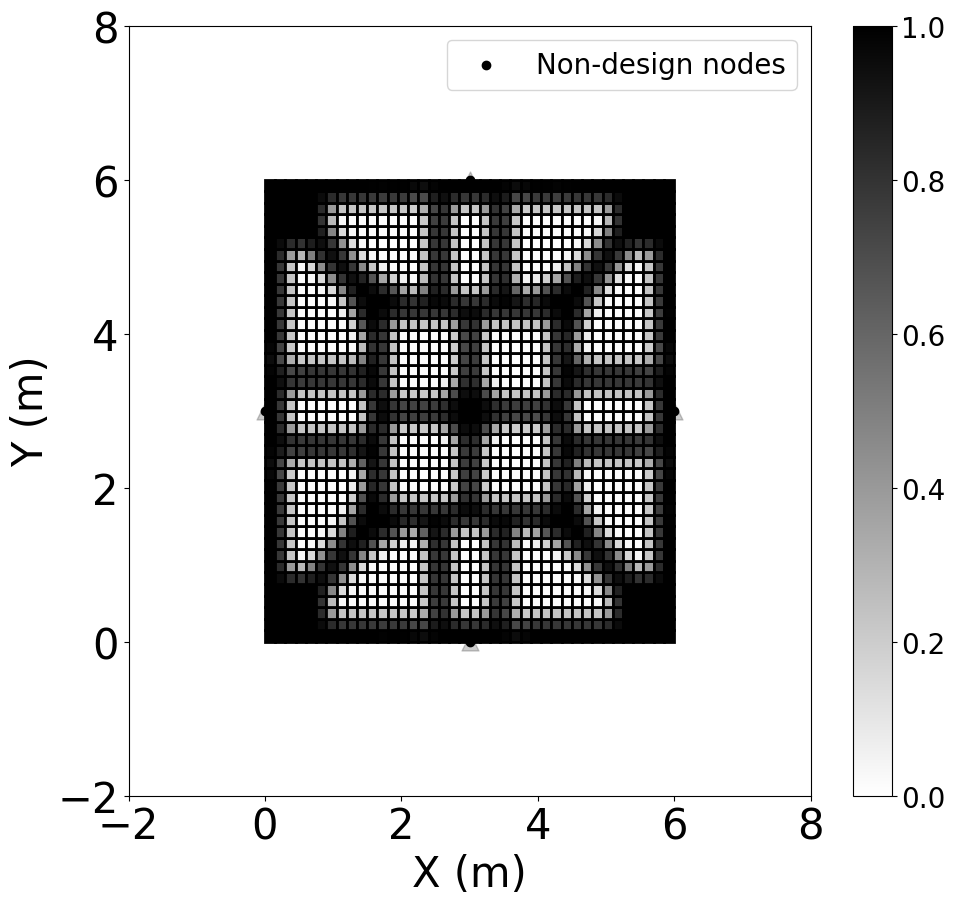

191th iteration, C = 1.6043969684542883 
192th iteration, C = 1.6061445627860782 
193th iteration, C = 1.6038497805805658 
194th iteration, C = 1.6031181360117563 
195th iteration, C = 1.6191582770252537 
799.9990683507363


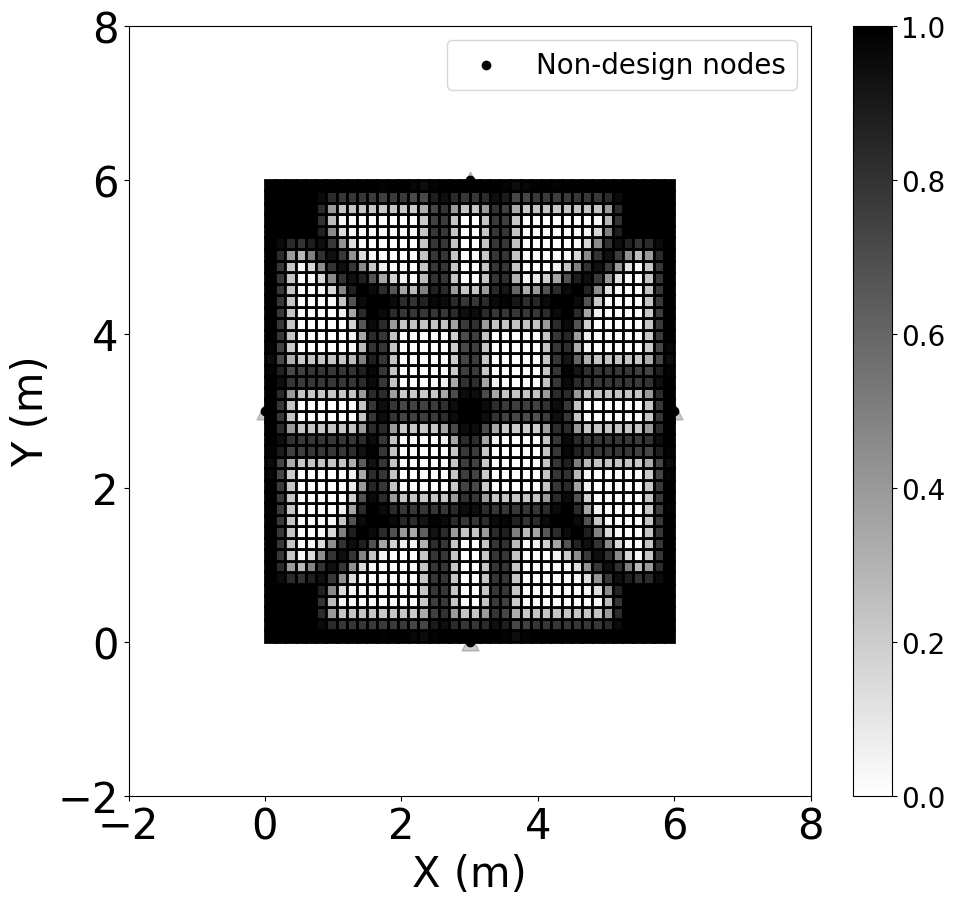

196th iteration, C = 1.6025463937689748 
197th iteration, C = 1.6015430604794823 
198th iteration, C = 2.098911594989365 
199th iteration, C = 1.6146442043033347 
200th iteration, C = 1.601134985745318 
799.9999737894472


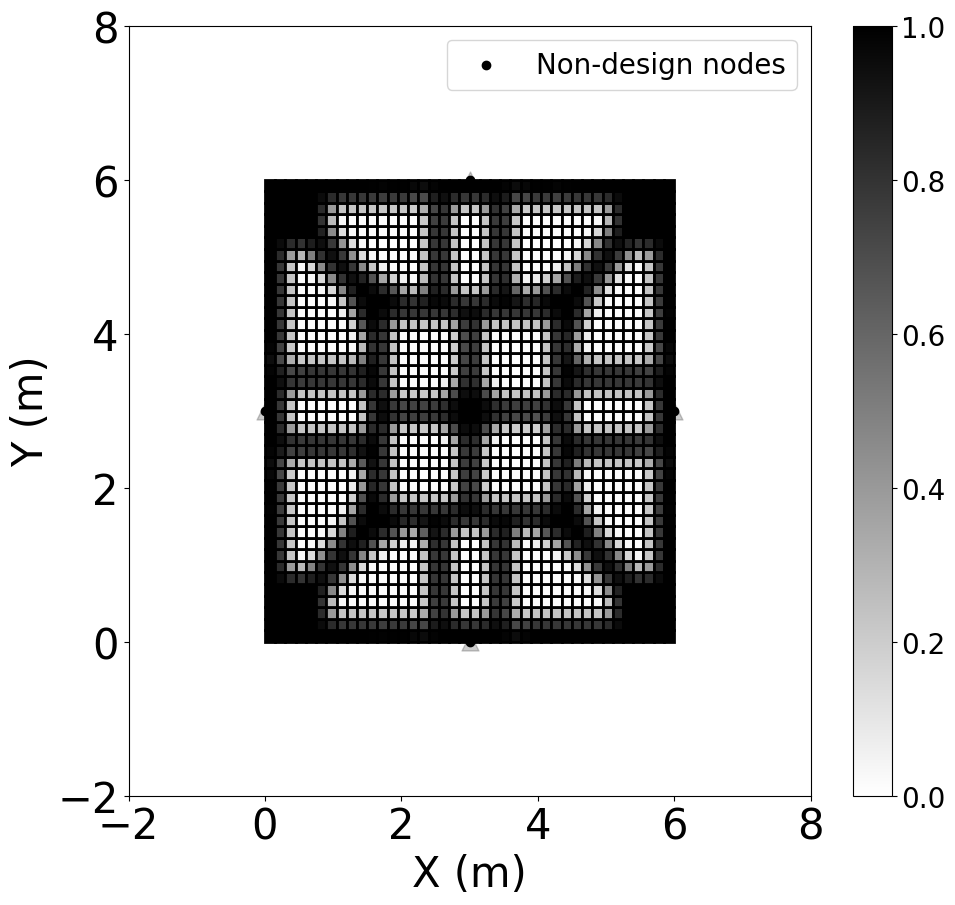

201th iteration, C = 1.6005119732202333 
202th iteration, C = 1.6123423277745783 
203th iteration, C = 1.5998094807454961 
204th iteration, C = 1.5997489100060243 
205th iteration, C = 1.6074489976419049 
799.9984739201388


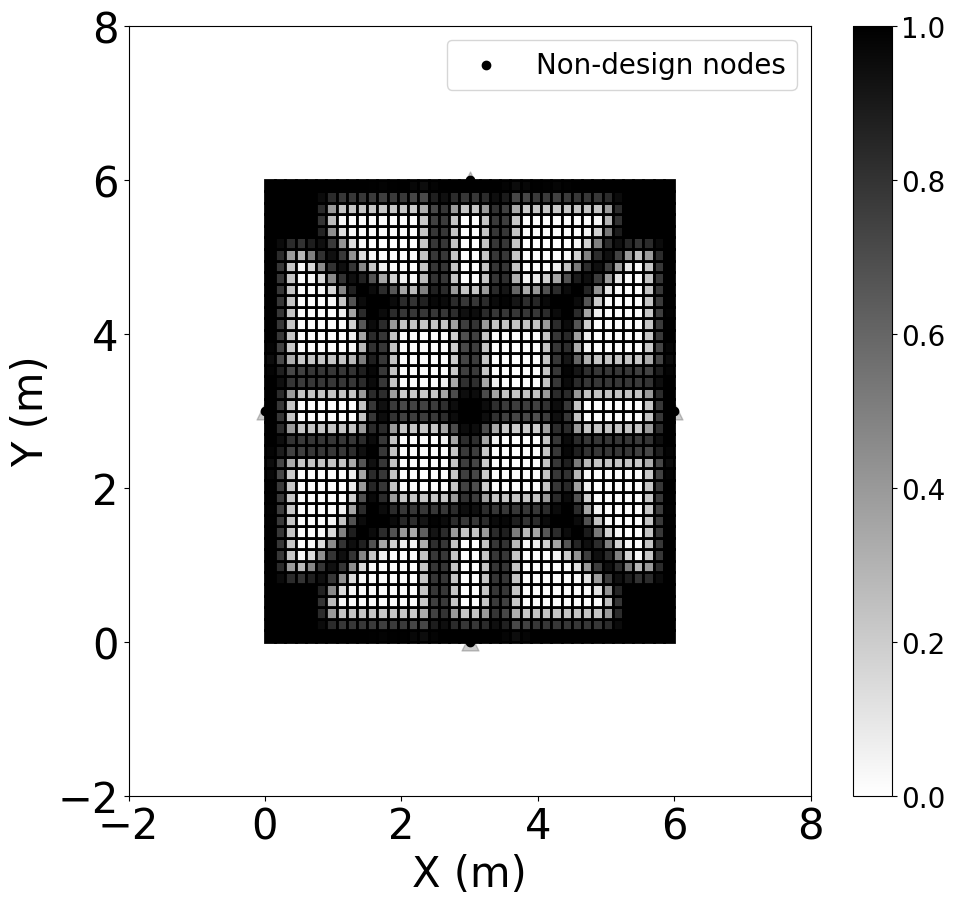

206th iteration, C = 1.5988270167276666 
207th iteration, C = 1.5987694643368027 
208th iteration, C = 1.6041673364235849 
209th iteration, C = 1.5978829261795469 
210th iteration, C = 1.598235897620543 
799.9965961490491


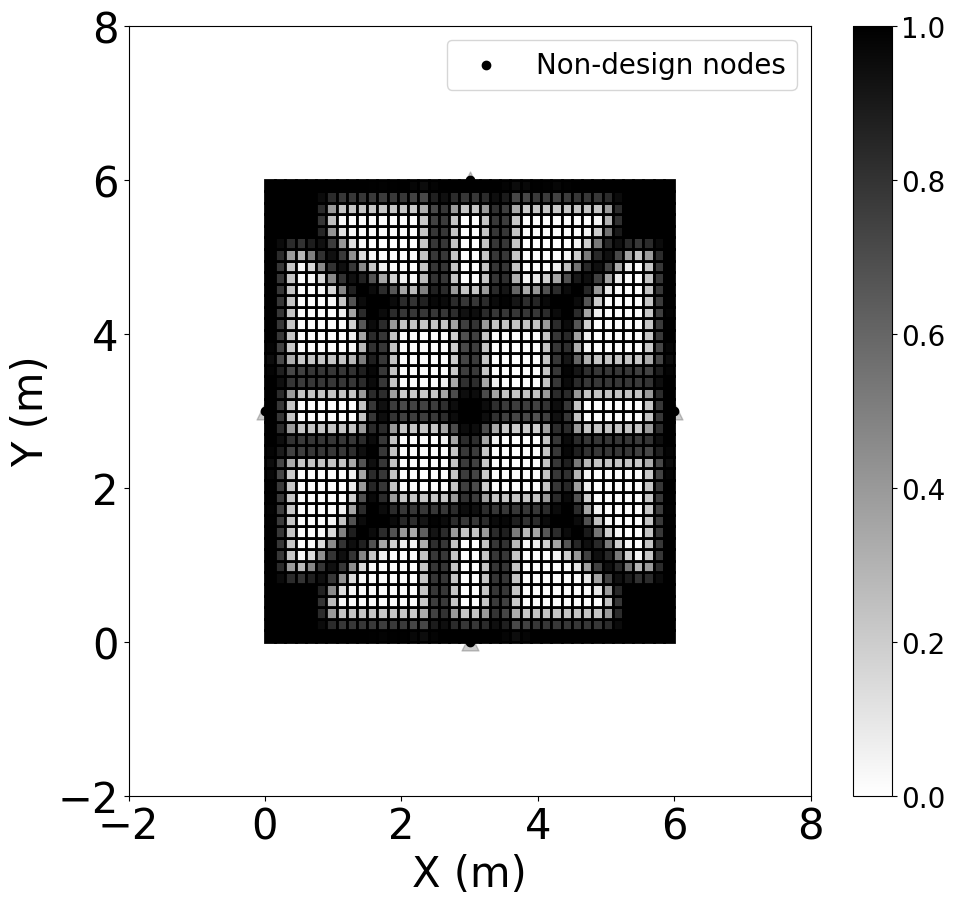

211th iteration, C = 1.5973205182304266 
212th iteration, C = 1.5974842273974743 
213th iteration, C = 1.5970443999649286 
214th iteration, C = 1.5993140529821046 
215th iteration, C = 1.5967742233965274 
799.9996435355234


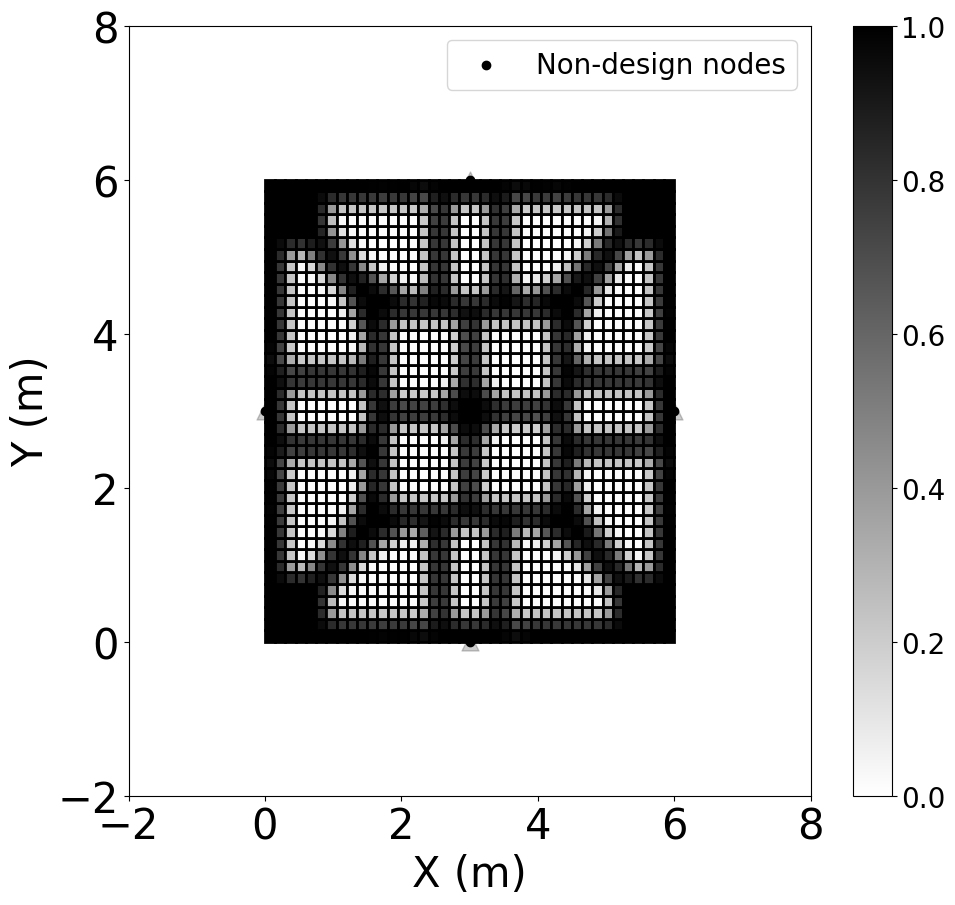

216th iteration, C = 1.6154376463601325 
217th iteration, C = 1.5965125952338535 
218th iteration, C = 1.5963764291203626 
219th iteration, C = 1.5960333206965296 
220th iteration, C = 1.595920676893181 
799.999959458821


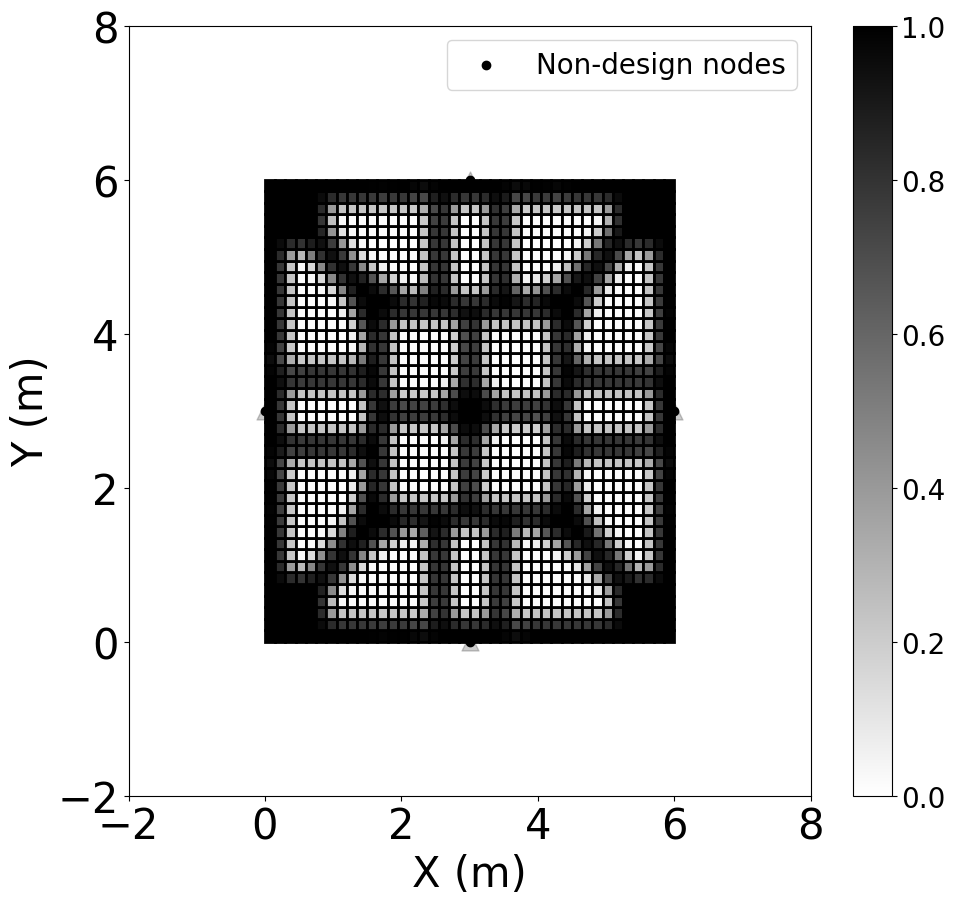

221th iteration, C = 1.5950553679270216 
222th iteration, C = 1.647985439953919 
223th iteration, C = 1.5953480393014878 
224th iteration, C = 1.5947682590797823 
225th iteration, C = 1.6219977329785964 
799.9850471688235


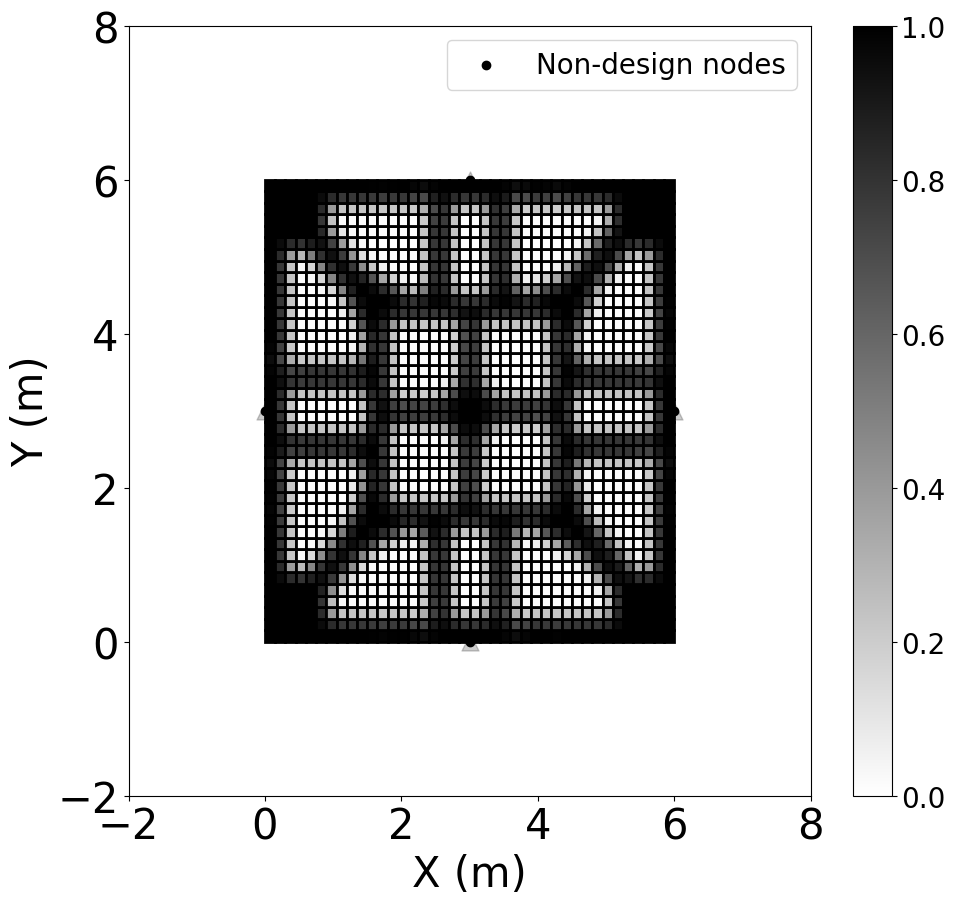

226th iteration, C = 1.5945189662150518 
227th iteration, C = 1.5943666702940085 
228th iteration, C = 1.5940571822473761 
229th iteration, C = 1.5938981097904084 
230th iteration, C = 1.5932905829330786 
799.9984733629185


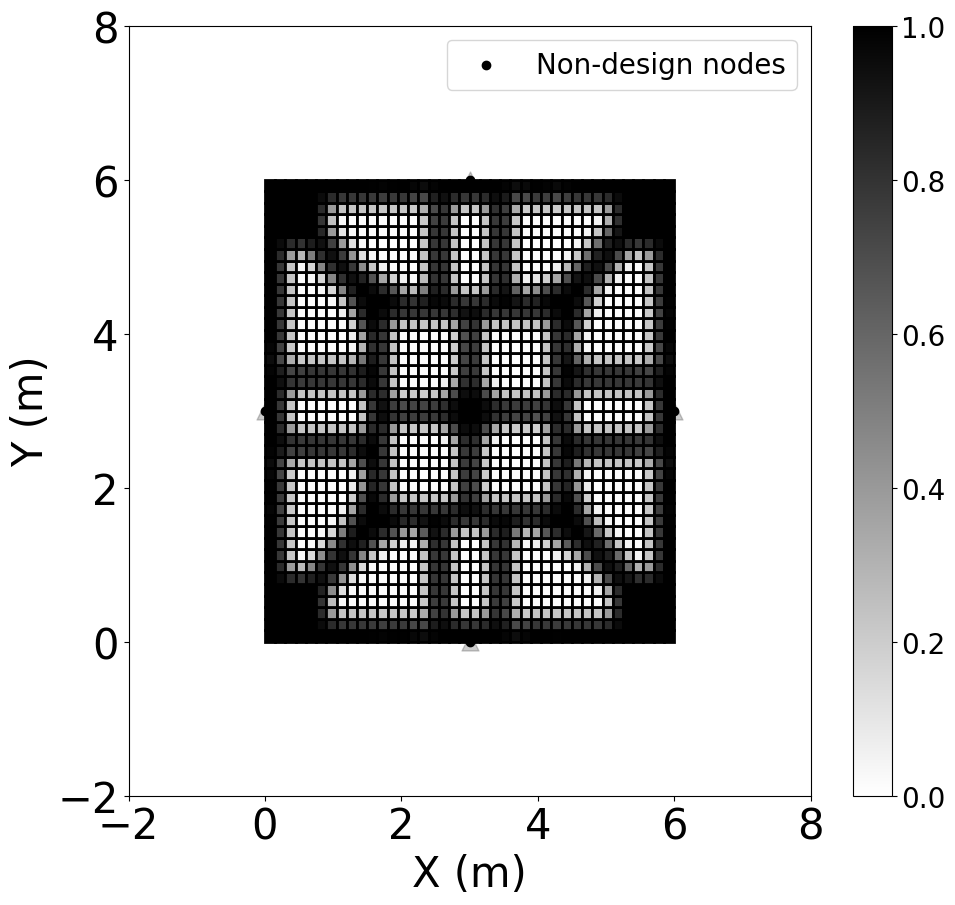

231th iteration, C = 1.7197180808349763 
232th iteration, C = 1.5958631638684195 
233th iteration, C = 1.5930658612149895 
234th iteration, C = 1.5926130475881564 
235th iteration, C = 1.6187690098739607 
799.9981253350085


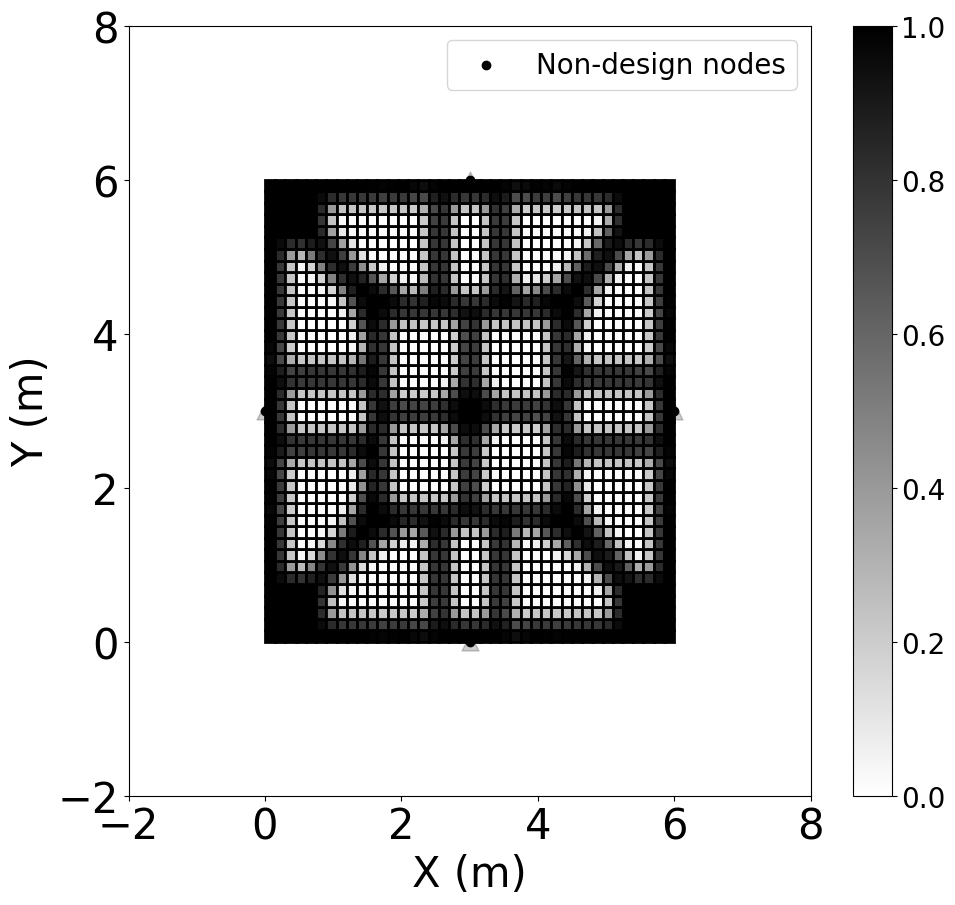

236th iteration, C = 1.5920759448555004 
237th iteration, C = 1.5924761207031959 
238th iteration, C = 1.591760486994039 
239th iteration, C = 1.6458338303651328 
240th iteration, C = 1.5919323419074878 
799.999742954183


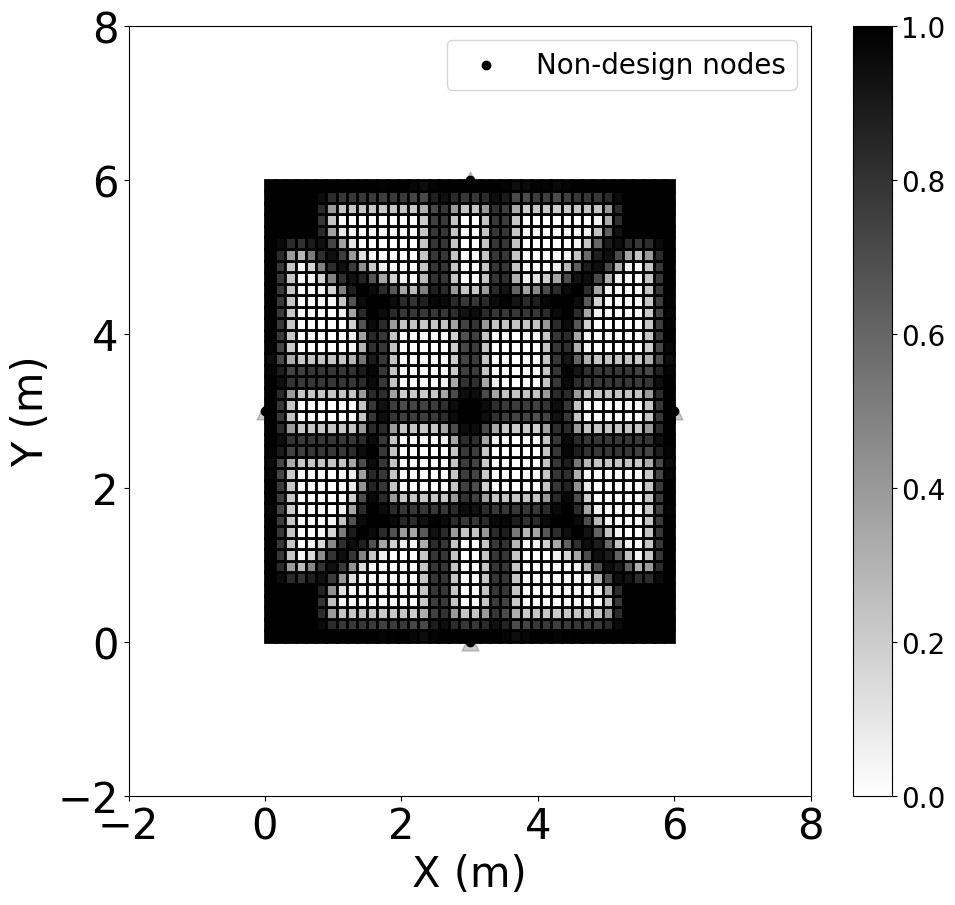

241th iteration, C = 1.5915938663048372 
242th iteration, C = 1.5910799556649335 
243th iteration, C = 1.6203480085020598 
244th iteration, C = 1.5906329995347317 
245th iteration, C = 1.5905122875803908 
799.9999752099868


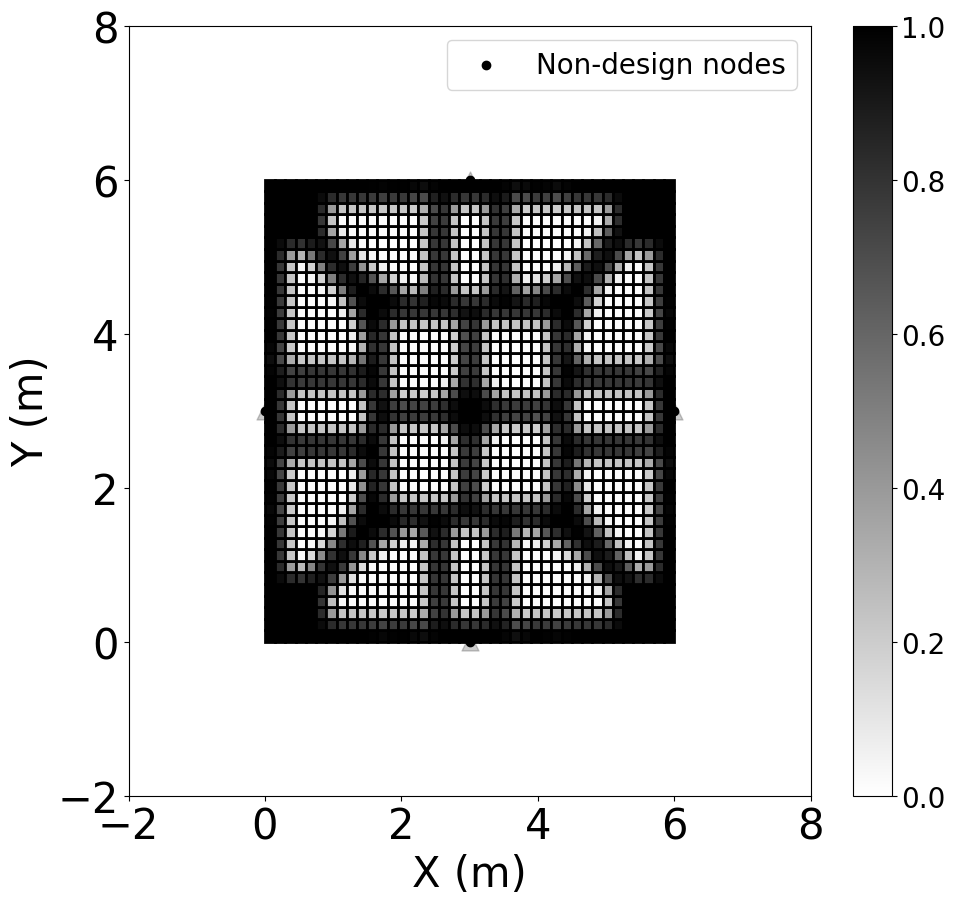

246th iteration, C = 1.5900870461485854 
247th iteration, C = 1.7793055752571885 
248th iteration, C = 1.5968265276695344 
249th iteration, C = 1.589815880079604 
250th iteration, C = 1.589103680762298 
799.996545995563


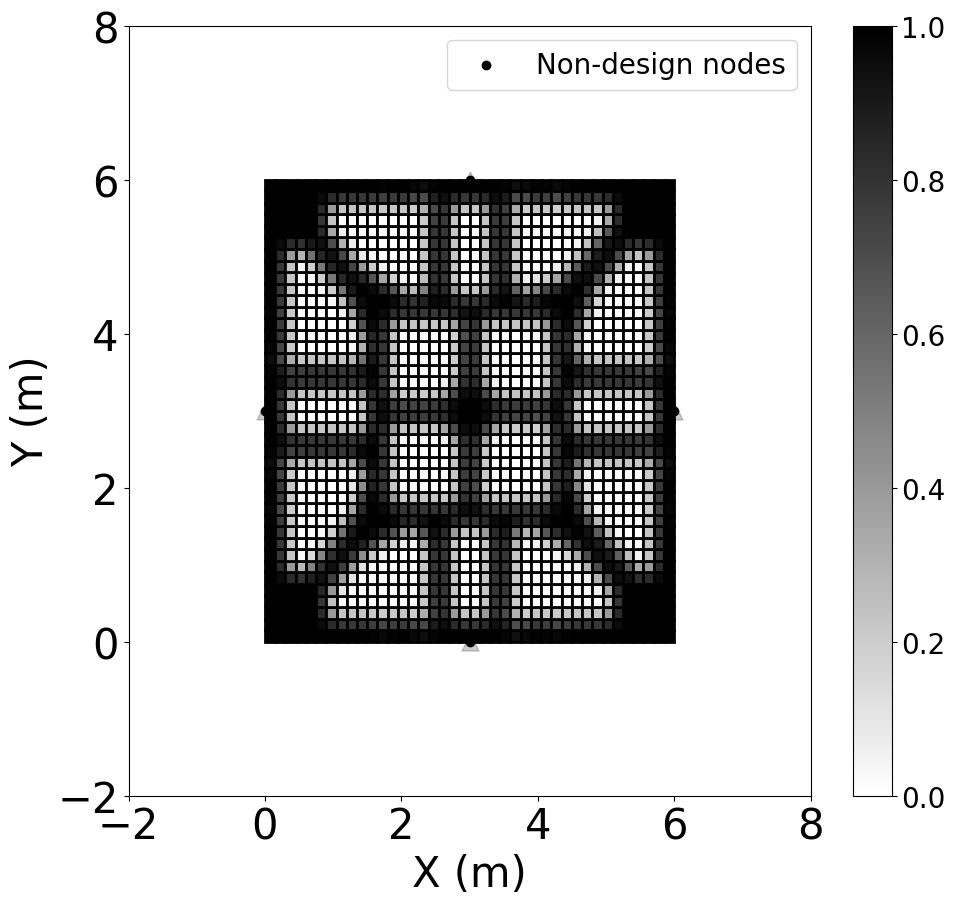

251th iteration, C = 1.6620913975784766 
252th iteration, C = 1.5903764315572775 
253th iteration, C = 1.5888917485853922 
254th iteration, C = 1.5920990302269324 
255th iteration, C = 1.588668443627096 
799.9993120250022


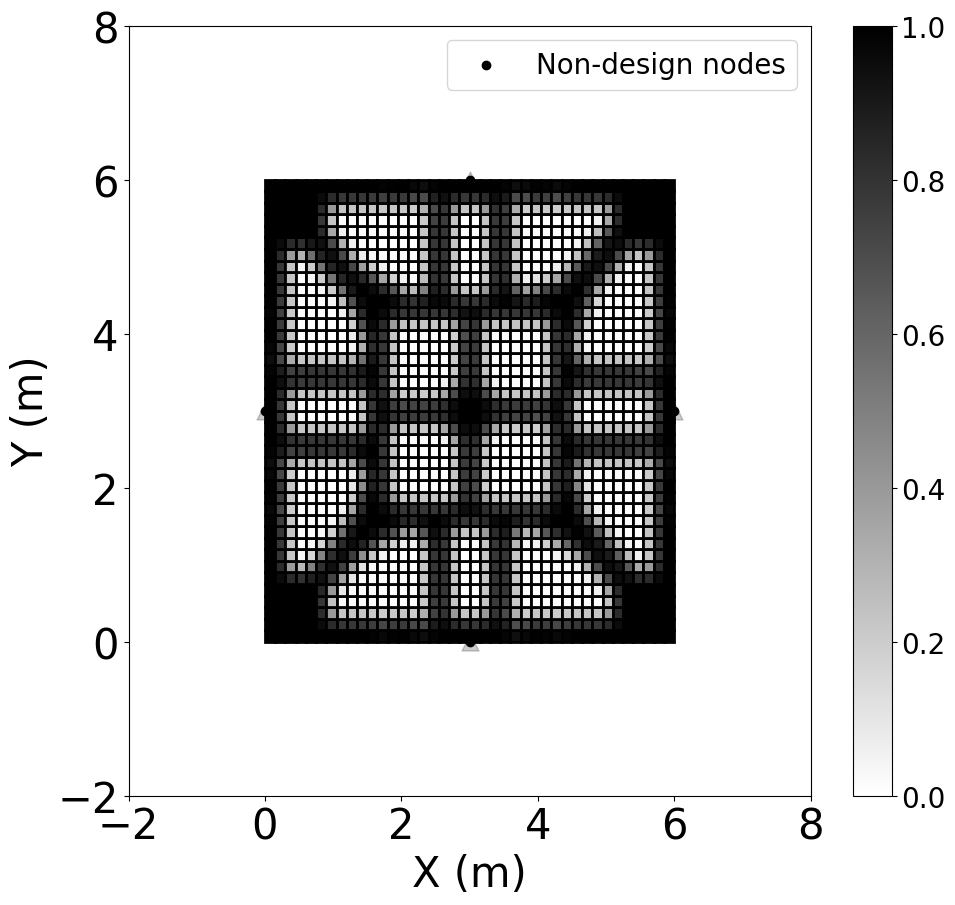

256th iteration, C = 1.6189242567803086 
257th iteration, C = 1.5885726987267397 
258th iteration, C = 1.5886201356958696 
259th iteration, C = 1.588334234348232 
260th iteration, C = 1.5878908150957811 
799.9972805052473


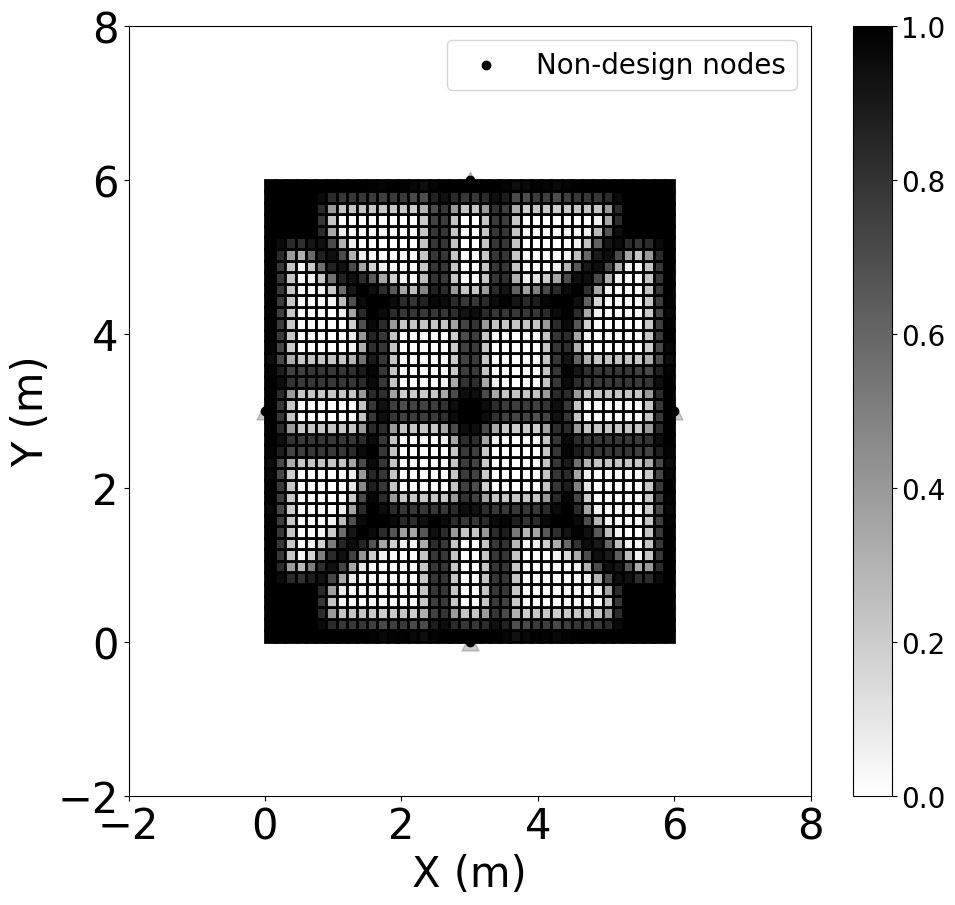

261th iteration, C = 1.746923085524111 
262th iteration, C = 1.5929045945146831 
263th iteration, C = 1.5876975337174764 
264th iteration, C = 1.5870710432035287 
265th iteration, C = 1.832829348759334 
799.9518739896739


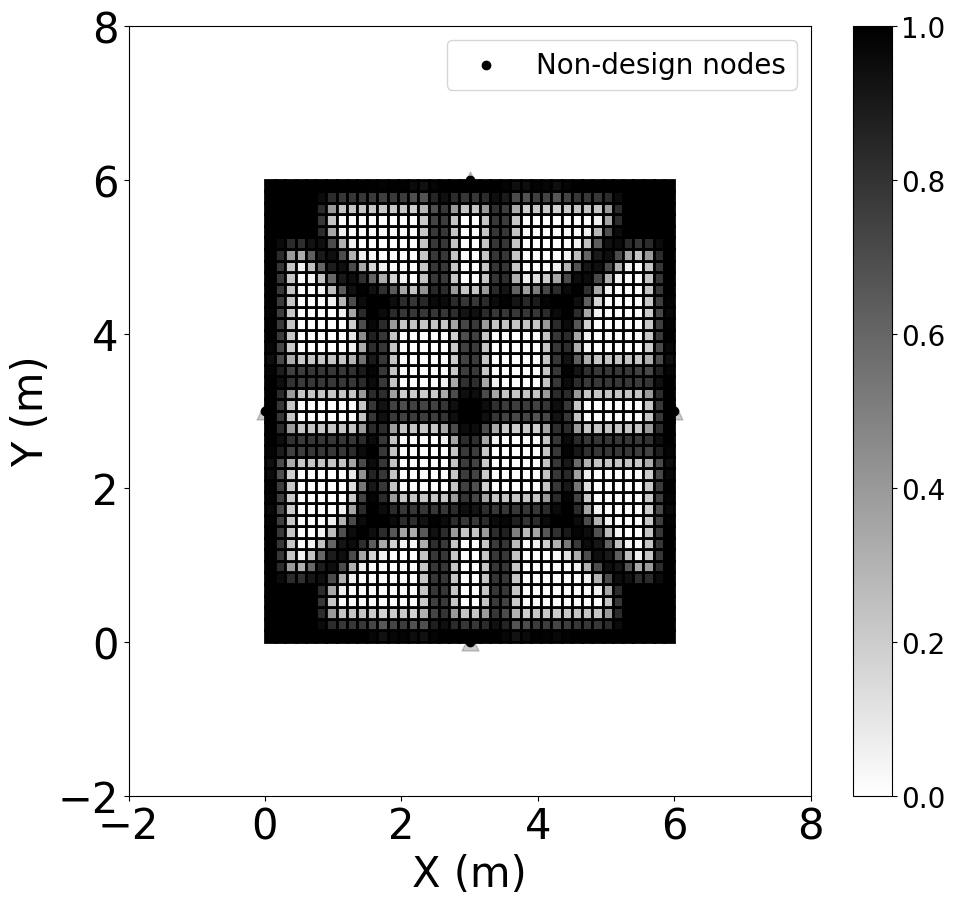

266th iteration, C = 1.5934171537921855 
267th iteration, C = 1.5867672363258345 
268th iteration, C = 1.5865614107147785 
269th iteration, C = 1.5915297504135724 
270th iteration, C = 1.5860430633953224 
799.9999167671801


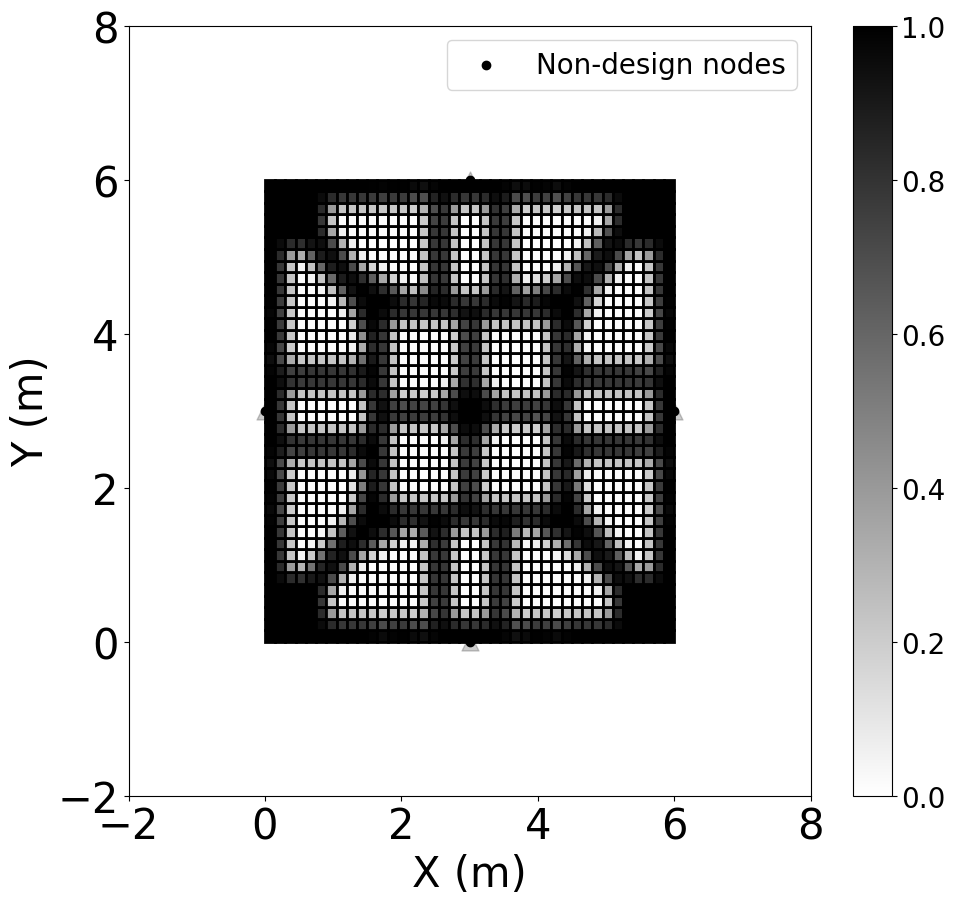

271th iteration, C = 1.5859476586764558 
272th iteration, C = 1.5857329489930718 
273th iteration, C = 1.5891434862289184 
274th iteration, C = 1.58554999477772 
275th iteration, C = 1.585554167598268 
799.9963978639487


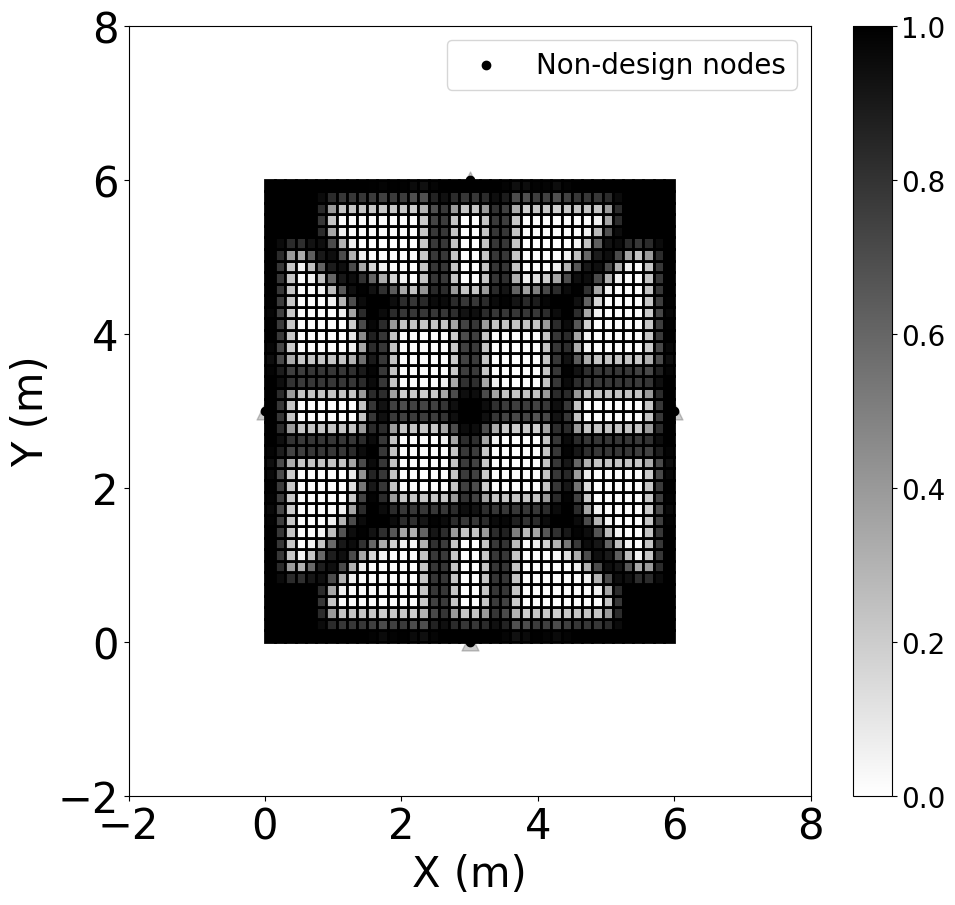

276th iteration, C = 1.5853969015893867 
277th iteration, C = 1.586039453296096 
278th iteration, C = 1.5852901708794147 
279th iteration, C = 1.5850042429673339 
280th iteration, C = 1.8475734462333941 
799.9645617948344


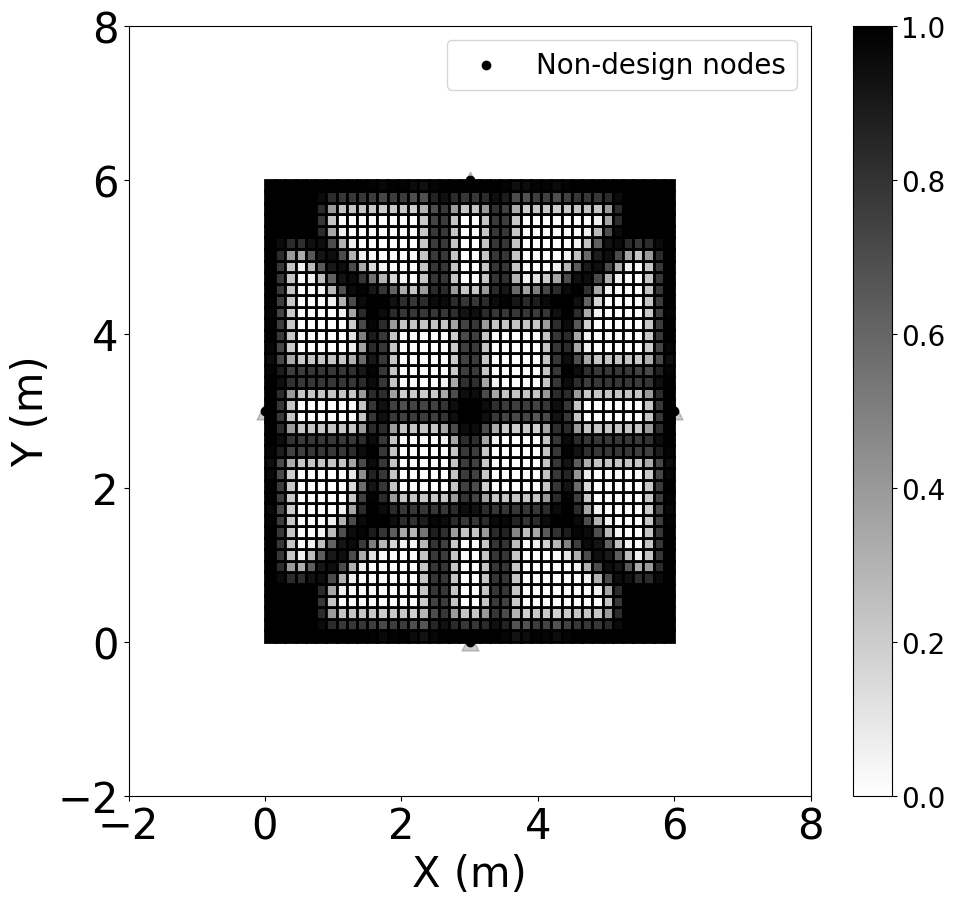

281th iteration, C = 1.5920849841863078 
282th iteration, C = 1.5848714723852806 
283th iteration, C = 1.5846270205832567 
284th iteration, C = 1.5895068528373233 
285th iteration, C = 1.5844188584515722 
799.9999268549109


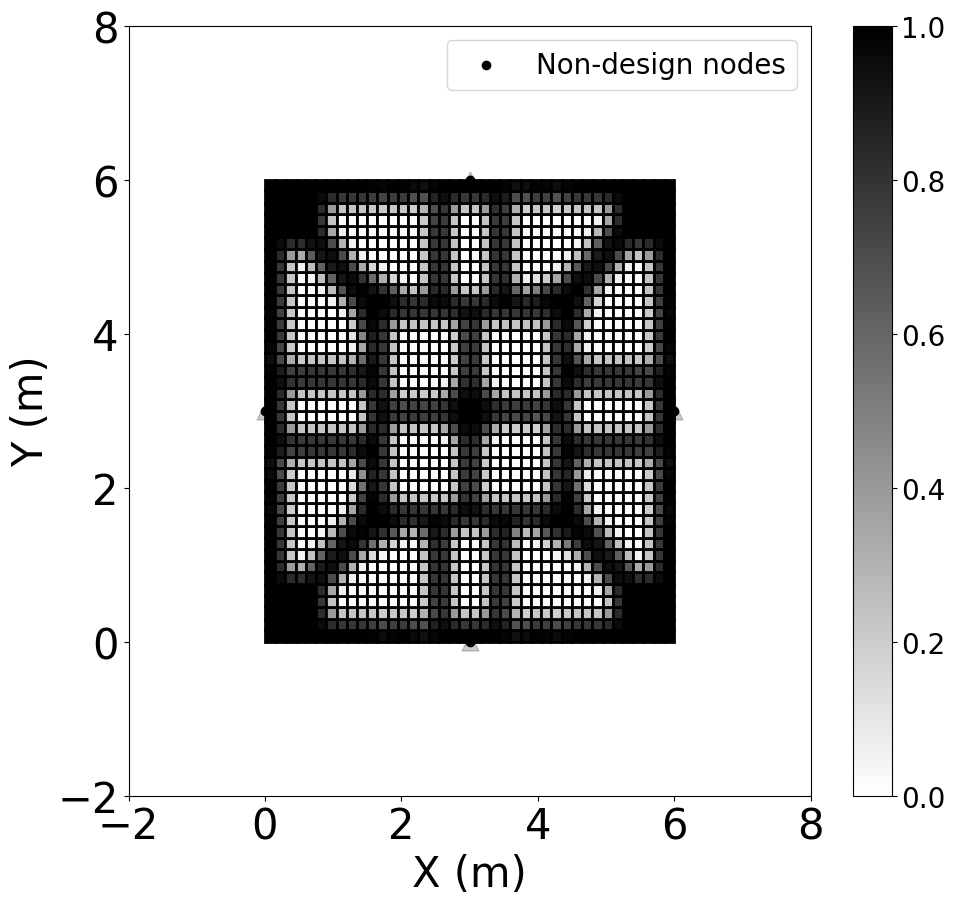

286th iteration, C = 1.5841568493892442 
287th iteration, C = 1.5891035163534213 
288th iteration, C = 1.5839429401588876 
289th iteration, C = 1.5848722714329904 
290th iteration, C = 1.5838189133032532 
799.9996903680651


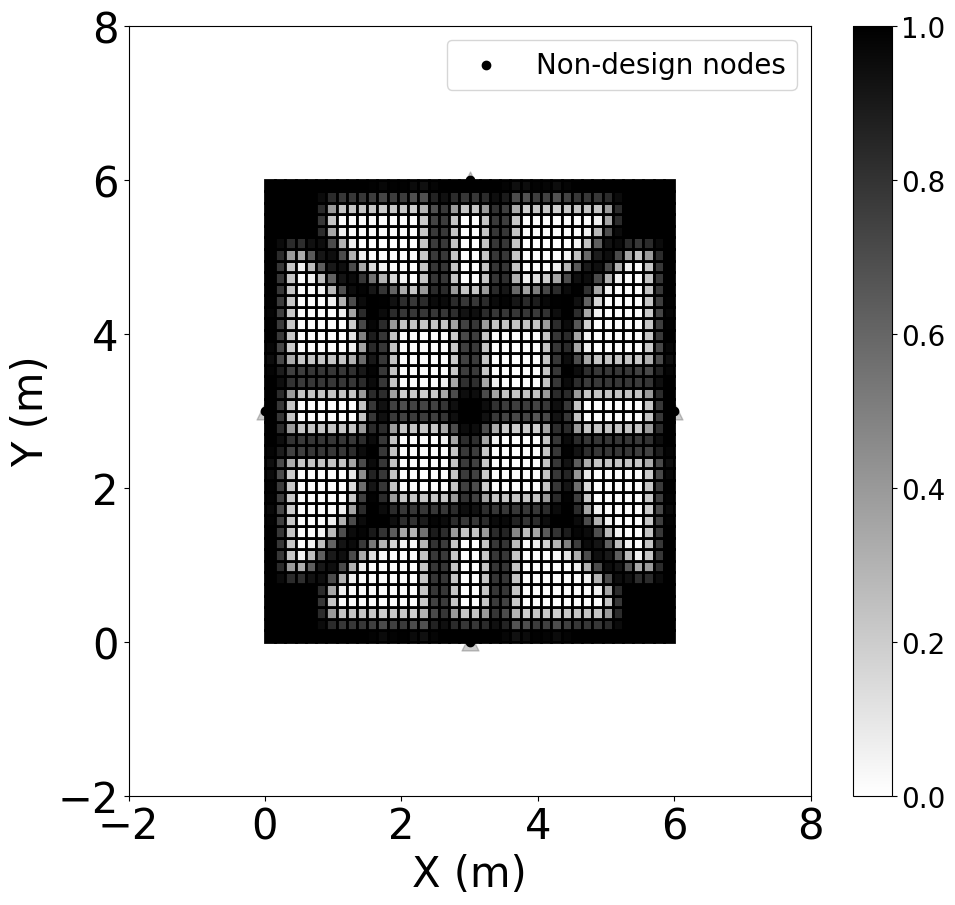

291th iteration, C = 1.583830536199641 
292th iteration, C = 1.5837336217400435 
293th iteration, C = 1.5834052132876326 
294th iteration, C = 1.744189864026718 
295th iteration, C = 1.5955500356469619 
799.9965658627726


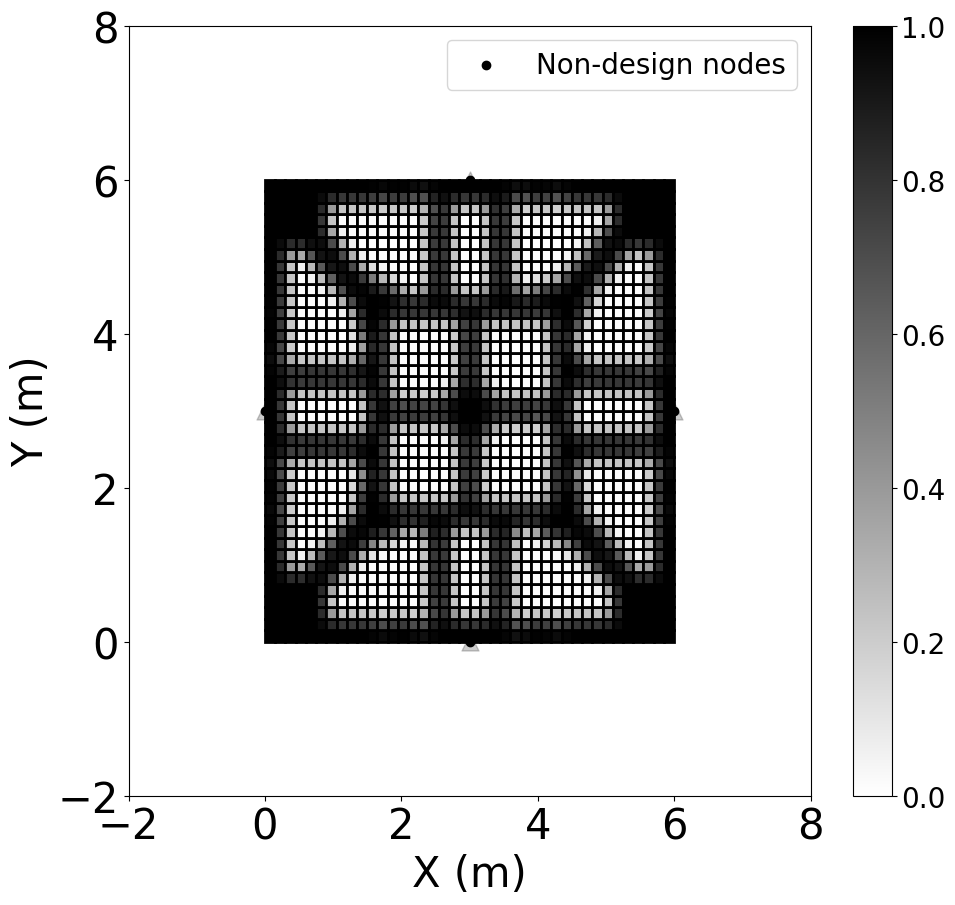

296th iteration, C = 1.5832554166530215 
297th iteration, C = 1.5831861017575528 
298th iteration, C = 1.5827852527668738 
299th iteration, C = 1.6649307663504054 
300th iteration, C = 1.5838058257203353 
799.9974603730321


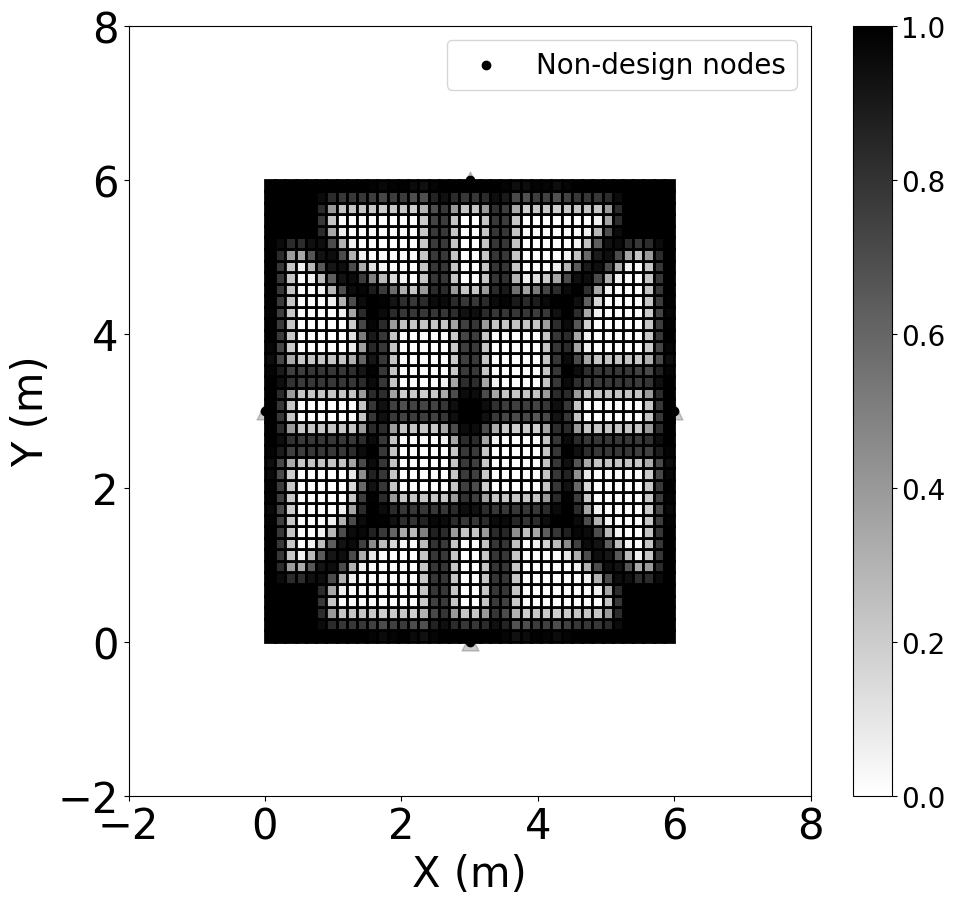

In [27]:
n_dim = sso_model.parameter_values.shape[0]
opt = nlopt.opt(nlopt.LD_MMA, n_dim)
opt.set_min_objective(f)
opt.set_lower_bounds(0.01*np.ones(n_dim)) # Lower bounds
opt.set_upper_bounds(np.ones(n_dim)) #Upper bounds
opt.set_maxeval(300)
opt.add_inequality_constraint(fc)
#xopt = opt.optimize(xopt)
xopt = opt.optimize(x_ini)

Text(0, 0.5, 'Total strain energy (N$\\cdot$m)')

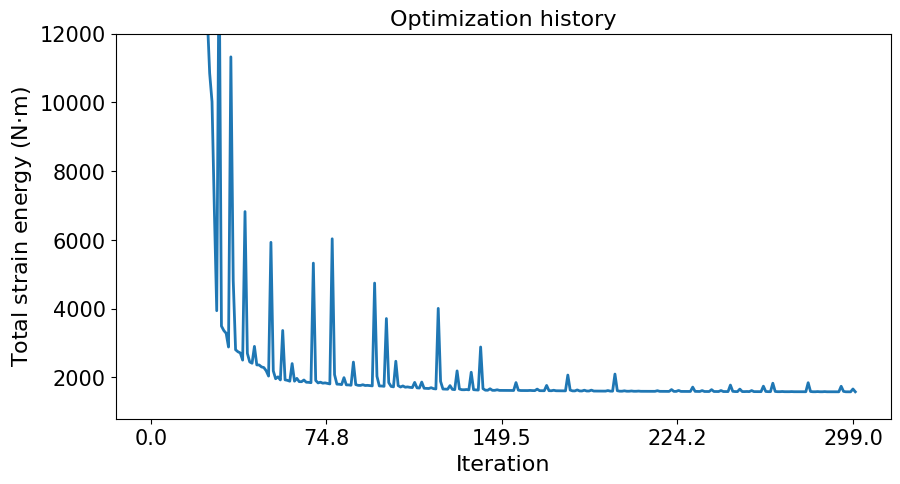

In [28]:

n_iter = np.array(C_hist).shape[0]
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(np.linspace(0,n_iter,n_iter),np.array(C_hist)*1000,linewidth=2)
plt.xticks(np.linspace(0,n_iter-1,5),fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim(800,12000)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (N$\cdot$m)',fontsize=16)

In [39]:
np.array(C_hist)*1000

array([2.06903705e+12, 1.73322119e+13, 1.73321578e+13, 1.73316170e+13,
       1.73262101e+13, 1.72373266e+13, 1.64109205e+13, 7.85524071e+12,
       8.88079713e+09, 6.34051475e+08, 6.19845079e+08, 5.10622509e+08,
       2.80860069e+08, 2.56736536e+08, 1.20288716e+08, 4.53775311e+06,
       4.23892800e+06, 1.97736808e+06, 1.87732934e+05, 1.69011856e+05,
       6.92896243e+04, 2.09128393e+04, 1.54351111e+04, 1.57482453e+04,
       1.25096223e+04, 1.08489937e+04, 1.00209270e+04, 6.84630247e+03,
       3.94235400e+03, 1.45990390e+04, 3.49582119e+03, 3.36560103e+03,
       3.28521358e+03, 2.88565944e+03, 1.13263517e+04, 4.81912995e+03,
       2.80707142e+03, 2.74799072e+03, 2.71401317e+03, 2.50491421e+03,
       6.82572447e+03, 2.70056343e+03, 2.45260558e+03, 2.41400718e+03,
       2.90450463e+03, 2.36542244e+03, 2.36379062e+03, 2.30745660e+03,
       2.28785784e+03, 2.19304154e+03, 2.04072535e+03, 5.93111930e+03,
       2.19225430e+03, 1.96290244e+03, 2.01925973e+03, 1.92762052e+03,
      

In [29]:
mu_opt = xopt[sso_model.nodeparameters_values.shape[0]:]
zs[design_nodes] = og_p(xopt[:sso_model.nodeparameters_values.shape[0]])
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

In [30]:
np.max(objective_filter(xopt)[1][sso_model.nodeparameters_values.shape[0]:])

301th iteration, C = 1.5827852527668738 


Array(-1.08683186e-13, dtype=float64)

In [31]:
np.min(objective_filter(xopt)[1][sso_model.nodeparameters_values.shape[0]:])

302th iteration, C = 1.5827852527668738 


Array(-0.77431288, dtype=float64)

# Visualization

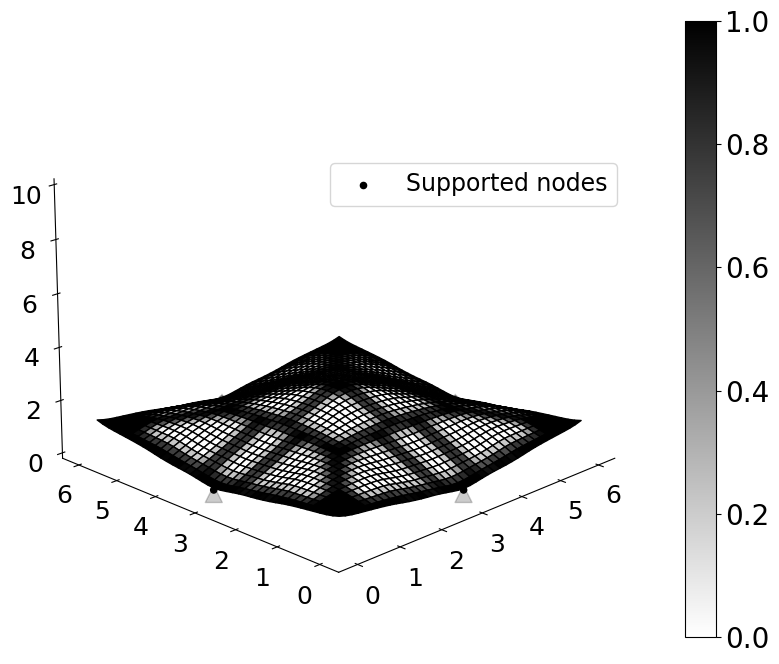

In [32]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.35,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]+0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [42]:
zs[non_design_nodes]

array([0.03, 0.03, 0.03, 0.03])

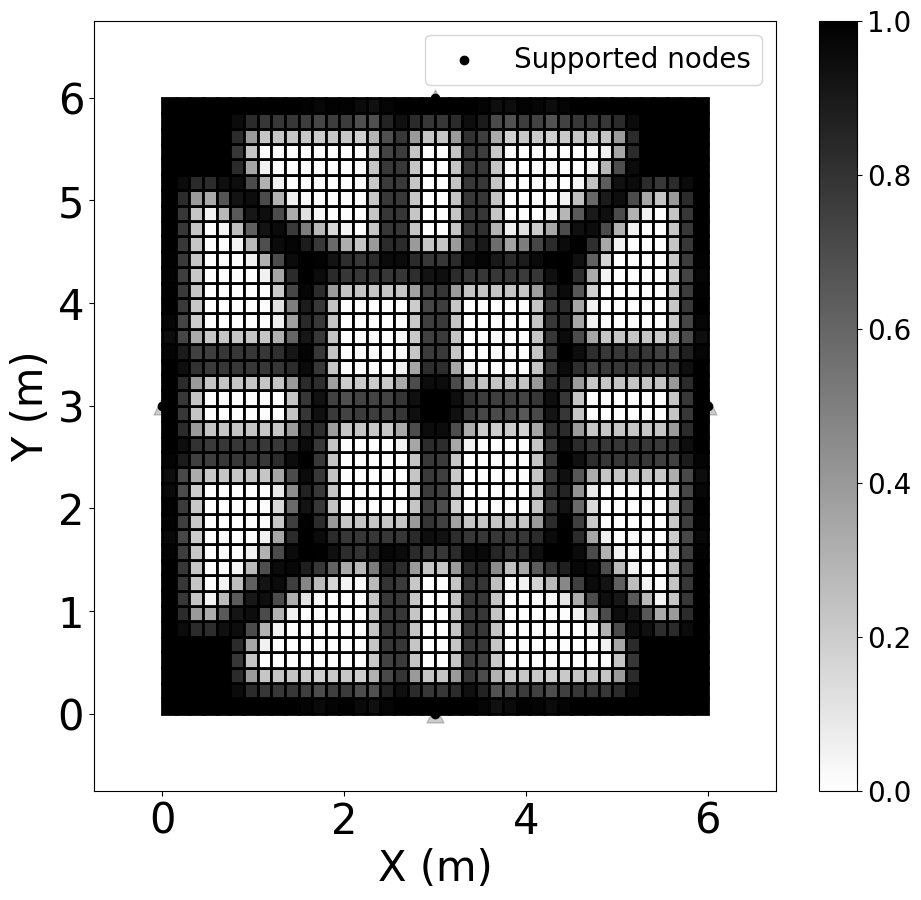

In [34]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

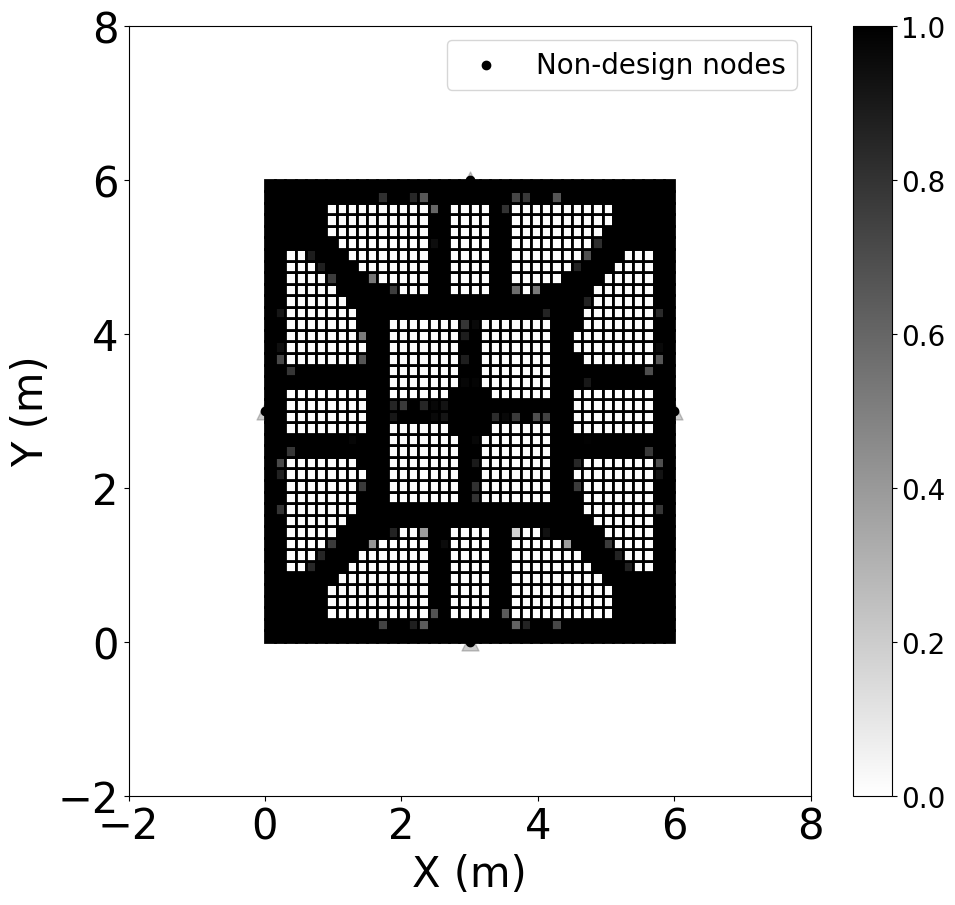

In [35]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [36]:
mu_opt

array([1., 1., 1., ..., 1., 1., 1.])

In [37]:
jnp.sum(mu_opt)

Array(799.99781556, dtype=float64)

In [38]:
0.5*sso_model.eleparameters_values.shape[0]

800.0

In [ ]:
mu_opt_filtered